# Control - NonControl Classification model with SetFit
# all-MiniLM-L12-v2

This notebook includes the current version of the code to predict and train a transformer model which indentifies if a control can matching with an acin control or not.

## Imports

In [1]:
import os
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sentence_transformers import SentenceTransformer

# Transformer
from core_functions.core import sentence_pairs_generation, train_random_init_setfit, get_predictions_setfit, describe_evaluation, get_predictions_ensemble, plot_calibration, plot_confidence_inc

In [4]:
#os.environ['CUDA_VISIBLE_DEVICES']='0'
os.environ['CUDA_VISIBLE_DEVICES']=''

In [5]:
import torch
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device("cpu")
print(device)

cpu


In [6]:
pd.set_option("display.max_colwidth", 200)

In [7]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [8]:
set_seed(15)

## Common definitions

In [9]:
# CHANGE HERE THE LOCATION OF MODELS AND DATA

cfilter_model_folder  = "master_project/data-spartan-master-thesis/Models/Classification_models/checkpoints"
language_model_folder = "/raid/shared/acin/models/control-noncontrol/language_model"

input_datafolder         = "/raid/shared/acin/data/clean/final_version"
control_input_datafolder = os.path.join(input_datafolder, "control-noncontrol")

st_model_folder = "../../../Models/Classification_models"  # Folder to sentence transformer models
checkpoint_model_folder = "../../../Models/Classification_models/checkpoints" # Checkpoint folder
output_folder = "results" # Results folder

In [10]:
# Paramters
external_label = 0                 ## Valid if we use a Dataset object with replacement (it means a new Label)
number_external_training = 5000    ## Number of external example to oversampling the training dataset
number_external_test = 500         ## Number of external example to oversampling the test dataset

Define the model type

## Dataset

In this section we generated the final `train` and `test` datasets.

### Acin dataset

In [11]:
train = pd.read_csv(os.path.join(control_input_datafolder,"control_nocontrol_train_ds.csv"))
test = pd.read_csv(os.path.join(control_input_datafolder,"control_nocontrol_test_ds.csv"))

In [12]:
train.head()

,Id,Text,Label
0,DB468D81-9AF0-4A74-B577-00111A7E8F6B,"On an Annual basis, Markets Surveillance_15. On an Annual basis, Markets Surveillance must review the Surveillance system and assess whether that system and the parameters and filters employed by ...",1
1,98EC052A-3641-4567-9ECF-001DBB00A128,[FRA] RSK/DRH/MMC/017 - Verification of the completeness and accuracy of the CED file addressed to Cand B. - CAR/MARK - GBI. The scope of the control concerns MARK France.From the file transmitted...,1
2,A1838041-33D4-4079-8B20-002FFB757EB1,Dealer Review of Trade Cost Analysis (TCA) (ASI). Daily Investment Control provide a TCA report for dealer review. Ensure best execution.,0
3,C16BAEC9-E301-4806-A368-00305D8B4703,(CR GCP) Tactical Intercompany Reconciliation. It refers to the interco reconciliation of corporate bond trades between CSSEL and CSSU to ensure there are matching entries in both the entities.An ...,1
4,FE9BA02D-AADA-4739-8A79-0044360D0526,"Maximum number of active orders. Inbound Throttle / speedbump WHAT: Maximum of 2000 active orders are accepted in Best X, after which Best X rejects new orders to Otex.WHO: Best X Algo performs th...",1


In [13]:
print(f"Number of training controls : {len(train)}")
print(f"Number of testing controls : {len(test)}")

Number of training controls : 6422
Number of testing controls : 616


In [14]:
train.head()

,Id,Text,Label
0,DB468D81-9AF0-4A74-B577-00111A7E8F6B,"On an Annual basis, Markets Surveillance_15. On an Annual basis, Markets Surveillance must review the Surveillance system and assess whether that system and the parameters and filters employed by ...",1
1,98EC052A-3641-4567-9ECF-001DBB00A128,[FRA] RSK/DRH/MMC/017 - Verification of the completeness and accuracy of the CED file addressed to Cand B. - CAR/MARK - GBI. The scope of the control concerns MARK France.From the file transmitted...,1
2,A1838041-33D4-4079-8B20-002FFB757EB1,Dealer Review of Trade Cost Analysis (TCA) (ASI). Daily Investment Control provide a TCA report for dealer review. Ensure best execution.,0
3,C16BAEC9-E301-4806-A368-00305D8B4703,(CR GCP) Tactical Intercompany Reconciliation. It refers to the interco reconciliation of corporate bond trades between CSSEL and CSSU to ensure there are matching entries in both the entities.An ...,1
4,FE9BA02D-AADA-4739-8A79-0044360D0526,"Maximum number of active orders. Inbound Throttle / speedbump WHAT: Maximum of 2000 active orders are accepted in Best X, after which Best X rejects new orders to Otex.WHO: Best X Algo performs th...",1


### External dataset

Post-processing option is using external texts to generate negative examples. 

In [15]:
# Load the external texts dataset (text from other sources)
extra_texts_df = pd.read_csv(os.path.join(input_datafolder, "other_datasets_false_texts.csv"))

# Define the structure of the training dataset
extra_texts_df["Label"] = external_label 
extra_texts_df['Id'] = extra_texts_df.index
extra_texts_df.head()

,Text,Label,Id
0,"By knowing the underlying concepts of how the software works, the tester makes better-informed testing choices while testing the software from outside. Typically, a grey-box tester will be permitt...",0,0
1,term under the Agreement will not be effective unless mutually agreed to in writing and signed by authorized representatives of both parties. Neither party shall be bound by typographical or cleri...,0,1
2,"Load testing is primarily concerned with testing that the system can continue to operate under a specific load, whether that be large quantities of data or a large number of users. This is general...",0,2
3,"Regression testing focuses on finding defects after a major code change has occurred. Specifically, it seeks to uncover software regressions, as degraded or lost features, including old bugs that ...",0,3
4,"[***] = CONFIDENTIAL TREATMENT REQUESTED\n\nSCHEDULE A Product License Schedule FORM This Product License Schedule is issued pursuant to the Software License, Customization and Maintenance Agreem...",0,4


In [16]:
train_pos = train[train["Label"]==True]
train_neg = train[train["Label"]==False]

print(f"Number of positive examples in training: {len(train_pos)}")
print(f"Number of negative examples in training: {len(train_neg)}")
print(f"Number of external negative texts: {len(extra_texts_df)}")

Number of positive examples in training: 5100
Number of negative examples in training: 1322
Number of external negative texts: 339521


#### Add samples of external examples

In this option of post-processing, we added a number of external documents as negative examples.

In [17]:
extra_texts_df = extra_texts_df.sample(frac=1, random_state=42) # Randomize extra texts

## Create an extended train
oversample_train = extra_texts_df.iloc[0:number_external_training, :]
train = pd.concat([train, oversample_train])
train = train.sample(frac=1) # Randomize

print(f'Number of training examples : {len(train)}')
print(f'\t - True examples : {len(train[train["Label"]==True])}')
print(f'\t - False examples : {len(train[train["Label"]==False])}')
print(f'\t - Other examples : {number_external_training}')
      
print()
print(f'Number of test examples : {len(test)}')
print(f'\t - True examples : {len(test[test["Label"]==True])}')
print(f'\t - False examples : {len(test[test["Label"]==False])}')

Number of training examples : 11422
	 - True examples : 5100
	 - False examples : 6322
	 - Other examples : 5000

Number of test examples : 616
	 - True examples : 519
	 - False examples : 97


In [18]:
# Create an extended test
oversample_test  = extra_texts_df.iloc[number_external_training:(number_external_training+number_external_test), :]
extended_test = pd.concat([test, oversample_test])

print()
print(f'Number of extended test examples : {len(extended_test)}')
print(f'\t - True examples : {len(extended_test[extended_test["Label"]==True])}')
print(f'\t - False examples : {len(extended_test[extended_test["Label"]==False])}')

extended_test['Text'] = extended_test['Text'].apply(lambda x : ' '.join(x.split(' ')[:550]))


Number of extended test examples : 1116
	 - True examples : 519
	 - False examples : 597


### Preprocess data

In [19]:
# Cap to max length (some models do not do it by themselves)
train['Text'] = train['Text'].apply(lambda x : ' '.join(x.split(' ')[:550]))
test['Text'] = test['Text'].apply(lambda x : ' '.join(x.split(' ')[:550]))
extended_test['Text'] = extended_test['Text'].apply(lambda x : ' '.join(x.split(' ')[:550]))

In [18]:
# SetFit options
#@param ['paraphrase-mpnet-base-v2', 'all-mpnet-base-v1', 'all-mpnet-base-v2', 'stsb-mpnet-base-v2', 'all-MiniLM-L12-v2', 'paraphrase-albert-small-v2', 'all-roberta-large-v1']
#@param ["8", "16", "32", "54", "128", "256", "512"] {type:"raw"}
#@param ["1", "2", "3", "4", "5", "10"] {type:"raw"}

## Training
Training a sentence transformer 8 times incrementally doubling the number of sentence pairs.

In [19]:
# Specificy the underlying sentence transformer here
sentence_transformer_model = 'all-MiniLM-L12-v2'

In [20]:
model_one = train_random_init_setfit(model_checkpoint= sentence_transformer_model,
                         train= train,
                         final_path = st_model_folder,
                         interim_path = checkpoint_model_folder,
                         num_training = 8,
                         num_itr= 1)

100%|██████████| 1/1 [00:00<00:00, 1007.04it/s]


2023-06-09 16:51:02 - ACIN dev dataset
2023-06-09 16:51:02 - Warmup-steps: 100
2023-06-09 16:51:02 - Model save path: ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_8_2023-06-09_16-51-02
2023-06-09 16:51:02 - Number of epochs: 10
2023-06-09 16:51:02 - Model sequence-len: 128


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

2023-06-09 16:51:04 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 0:
2023-06-09 16:51:04 - Cosine-Similarity :	Pearson: 0.4715	Spearman: 0.3536
2023-06-09 16:51:04 - Manhattan-Distance:	Pearson: 0.3776	Spearman: 0.3536
2023-06-09 16:51:04 - Euclidean-Distance:	Pearson: 0.4765	Spearman: 0.3536
2023-06-09 16:51:04 - Dot-Product-Similarity:	Pearson: 0.4715	Spearman: 0.3536
2023-06-09 16:51:04 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_8_2023-06-09_16-51-02


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

2023-06-09 16:51:05 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 1:
2023-06-09 16:51:05 - Cosine-Similarity :	Pearson: 0.4748	Spearman: 0.3536
2023-06-09 16:51:05 - Manhattan-Distance:	Pearson: 0.3811	Spearman: 0.3536
2023-06-09 16:51:05 - Euclidean-Distance:	Pearson: 0.4797	Spearman: 0.3536
2023-06-09 16:51:05 - Dot-Product-Similarity:	Pearson: 0.4748	Spearman: 0.3536


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

2023-06-09 16:51:05 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 2:
2023-06-09 16:51:05 - Cosine-Similarity :	Pearson: 0.4816	Spearman: 0.3536
2023-06-09 16:51:05 - Manhattan-Distance:	Pearson: 0.3884	Spearman: 0.3536
2023-06-09 16:51:05 - Euclidean-Distance:	Pearson: 0.4862	Spearman: 0.3536
2023-06-09 16:51:05 - Dot-Product-Similarity:	Pearson: 0.4816	Spearman: 0.3536


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

2023-06-09 16:51:05 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 3:
2023-06-09 16:51:05 - Cosine-Similarity :	Pearson: 0.4938	Spearman: 0.3536
2023-06-09 16:51:05 - Manhattan-Distance:	Pearson: 0.4009	Spearman: 0.3536
2023-06-09 16:51:05 - Euclidean-Distance:	Pearson: 0.4976	Spearman: 0.3536
2023-06-09 16:51:05 - Dot-Product-Similarity:	Pearson: 0.4938	Spearman: 0.3536


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

2023-06-09 16:51:05 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 4:
2023-06-09 16:51:06 - Cosine-Similarity :	Pearson: 0.5059	Spearman: 0.3536
2023-06-09 16:51:06 - Manhattan-Distance:	Pearson: 0.4135	Spearman: 0.3536
2023-06-09 16:51:06 - Euclidean-Distance:	Pearson: 0.5089	Spearman: 0.3536
2023-06-09 16:51:06 - Dot-Product-Similarity:	Pearson: 0.5059	Spearman: 0.3536


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

2023-06-09 16:51:06 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 5:
2023-06-09 16:51:06 - Cosine-Similarity :	Pearson: 0.5229	Spearman: 0.3536
2023-06-09 16:51:06 - Manhattan-Distance:	Pearson: 0.4318	Spearman: 0.3536
2023-06-09 16:51:06 - Euclidean-Distance:	Pearson: 0.5248	Spearman: 0.3536
2023-06-09 16:51:06 - Dot-Product-Similarity:	Pearson: 0.5229	Spearman: 0.3536


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

2023-06-09 16:51:06 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 6:
2023-06-09 16:51:06 - Cosine-Similarity :	Pearson: 0.5422	Spearman: 0.3536
2023-06-09 16:51:06 - Manhattan-Distance:	Pearson: 0.4538	Spearman: 0.3536
2023-06-09 16:51:06 - Euclidean-Distance:	Pearson: 0.5427	Spearman: 0.3536
2023-06-09 16:51:06 - Dot-Product-Similarity:	Pearson: 0.5422	Spearman: 0.3536


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

2023-06-09 16:51:06 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 7:
2023-06-09 16:51:06 - Cosine-Similarity :	Pearson: 0.5604	Spearman: 0.3536
2023-06-09 16:51:06 - Manhattan-Distance:	Pearson: 0.4760	Spearman: 0.3536
2023-06-09 16:51:06 - Euclidean-Distance:	Pearson: 0.5594	Spearman: 0.3536
2023-06-09 16:51:06 - Dot-Product-Similarity:	Pearson: 0.5604	Spearman: 0.3536


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

2023-06-09 16:51:06 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 8:
2023-06-09 16:51:06 - Cosine-Similarity :	Pearson: 0.5832	Spearman: 0.3536
2023-06-09 16:51:06 - Manhattan-Distance:	Pearson: 0.5039	Spearman: 0.3536
2023-06-09 16:51:06 - Euclidean-Distance:	Pearson: 0.5805	Spearman: 0.3536
2023-06-09 16:51:06 - Dot-Product-Similarity:	Pearson: 0.5832	Spearman: 0.3536


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

2023-06-09 16:51:06 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 9:
2023-06-09 16:51:06 - Cosine-Similarity :	Pearson: 0.6096	Spearman: 0.7071
2023-06-09 16:51:06 - Manhattan-Distance:	Pearson: 0.5357	Spearman: 0.3536
2023-06-09 16:51:06 - Euclidean-Distance:	Pearson: 0.6049	Spearman: 0.7071
2023-06-09 16:51:06 - Dot-Product-Similarity:	Pearson: 0.6096	Spearman: 0.7071
2023-06-09 16:51:06 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_8_2023-06-09_16-51-02
2023-06-09 16:51:07 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_8_2023-06-09_16-51-02/20
The amount of training time required on A100 GPU is 4.762444 seconds.


In [21]:
model_two = train_random_init_setfit(model_checkpoint= sentence_transformer_model,
                         train= train,
                         final_path = st_model_folder,
                         interim_path = checkpoint_model_folder,
                         num_training = 16,
                         num_itr= 1)

2023-06-09 16:51:21 - Load pretrained SentenceTransformer: all-MiniLM-L12-v2
2023-06-09 16:51:21 - Use pytorch device: cuda


100%|██████████| 1/1 [00:00<00:00, 405.29it/s]

2023-06-09 16:51:21 - Load pretrained SentenceTransformer: all-MiniLM-L12-v2


2023-06-09 16:51:22 - Use pytorch device: cuda
2023-06-09 16:51:22 - ACIN dev dataset
2023-06-09 16:51:22 - Warmup-steps: 100
2023-06-09 16:51:22 - Model save path: ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_16_2023-06-09_16-51-22
2023-06-09 16:51:22 - Number of epochs: 10
2023-06-09 16:51:22 - Model sequence-len: 128


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

2023-06-09 16:51:22 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 0:
2023-06-09 16:51:22 - Cosine-Similarity :	Pearson: 0.2945	Spearman: 0.2611
2023-06-09 16:51:22 - Manhattan-Distance:	Pearson: 0.2527	Spearman: 0.2611
2023-06-09 16:51:22 - Euclidean-Distance:	Pearson: 0.2439	Spearman: 0.2611
2023-06-09 16:51:22 - Dot-Product-Similarity:	Pearson: 0.2945	Spearman: 0.2611
2023-06-09 16:51:22 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_16_2023-06-09_16-51-22


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

2023-06-09 16:51:23 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 1:
2023-06-09 16:51:23 - Cosine-Similarity :	Pearson: 0.3037	Spearman: 0.2611
2023-06-09 16:51:23 - Manhattan-Distance:	Pearson: 0.2583	Spearman: 0.3482
2023-06-09 16:51:23 - Euclidean-Distance:	Pearson: 0.2496	Spearman: 0.2611
2023-06-09 16:51:23 - Dot-Product-Similarity:	Pearson: 0.3037	Spearman: 0.2611
2023-06-09 16:51:23 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_16_2023-06-09_16-51-22


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

2023-06-09 16:51:23 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 2:
2023-06-09 16:51:23 - Cosine-Similarity :	Pearson: 0.3210	Spearman: 0.2611
2023-06-09 16:51:23 - Manhattan-Distance:	Pearson: 0.2681	Spearman: 0.3482
2023-06-09 16:51:23 - Euclidean-Distance:	Pearson: 0.2597	Spearman: 0.2611
2023-06-09 16:51:23 - Dot-Product-Similarity:	Pearson: 0.3210	Spearman: 0.2611


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

2023-06-09 16:51:24 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 3:
2023-06-09 16:51:24 - Cosine-Similarity :	Pearson: 0.3444	Spearman: 0.5222
2023-06-09 16:51:24 - Manhattan-Distance:	Pearson: 0.2818	Spearman: 0.5222
2023-06-09 16:51:24 - Euclidean-Distance:	Pearson: 0.2742	Spearman: 0.5222
2023-06-09 16:51:24 - Dot-Product-Similarity:	Pearson: 0.3444	Spearman: 0.5222
2023-06-09 16:51:24 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_16_2023-06-09_16-51-22


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

2023-06-09 16:51:24 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 4:
2023-06-09 16:51:24 - Cosine-Similarity :	Pearson: 0.3767	Spearman: 0.5222
2023-06-09 16:51:24 - Manhattan-Distance:	Pearson: 0.3013	Spearman: 0.5222
2023-06-09 16:51:24 - Euclidean-Distance:	Pearson: 0.2942	Spearman: 0.5222
2023-06-09 16:51:24 - Dot-Product-Similarity:	Pearson: 0.3767	Spearman: 0.5222


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

2023-06-09 16:51:25 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 5:
2023-06-09 16:51:25 - Cosine-Similarity :	Pearson: 0.4199	Spearman: 0.5222
2023-06-09 16:51:25 - Manhattan-Distance:	Pearson: 0.3279	Spearman: 0.5222
2023-06-09 16:51:25 - Euclidean-Distance:	Pearson: 0.3211	Spearman: 0.5222
2023-06-09 16:51:25 - Dot-Product-Similarity:	Pearson: 0.4199	Spearman: 0.5222


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

2023-06-09 16:51:25 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 6:
2023-06-09 16:51:25 - Cosine-Similarity :	Pearson: 0.4756	Spearman: 0.5222
2023-06-09 16:51:25 - Manhattan-Distance:	Pearson: 0.3643	Spearman: 0.5222
2023-06-09 16:51:25 - Euclidean-Distance:	Pearson: 0.3572	Spearman: 0.5222
2023-06-09 16:51:25 - Dot-Product-Similarity:	Pearson: 0.4756	Spearman: 0.5222


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

2023-06-09 16:51:25 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 7:
2023-06-09 16:51:25 - Cosine-Similarity :	Pearson: 0.5476	Spearman: 0.6093
2023-06-09 16:51:25 - Manhattan-Distance:	Pearson: 0.4127	Spearman: 0.6963
2023-06-09 16:51:25 - Euclidean-Distance:	Pearson: 0.4052	Spearman: 0.6093
2023-06-09 16:51:25 - Dot-Product-Similarity:	Pearson: 0.5476	Spearman: 0.6093
2023-06-09 16:51:25 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_16_2023-06-09_16-51-22


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

2023-06-09 16:51:26 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 8:
2023-06-09 16:51:26 - Cosine-Similarity :	Pearson: 0.6352	Spearman: 0.6963
2023-06-09 16:51:26 - Manhattan-Distance:	Pearson: 0.4733	Spearman: 0.6963
2023-06-09 16:51:26 - Euclidean-Distance:	Pearson: 0.4662	Spearman: 0.6963
2023-06-09 16:51:26 - Dot-Product-Similarity:	Pearson: 0.6352	Spearman: 0.6963


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

2023-06-09 16:51:26 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 9:
2023-06-09 16:51:26 - Cosine-Similarity :	Pearson: 0.7410	Spearman: 0.6963
2023-06-09 16:51:26 - Manhattan-Distance:	Pearson: 0.5531	Spearman: 0.6963
2023-06-09 16:51:26 - Euclidean-Distance:	Pearson: 0.5476	Spearman: 0.6963
2023-06-09 16:51:26 - Dot-Product-Similarity:	Pearson: 0.7410	Spearman: 0.6963
2023-06-09 16:51:26 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_16_2023-06-09_16-51-22/40
The amount of training time required on A100 GPU is 4.817663 seconds.


In [22]:
model_three = train_random_init_setfit(model_checkpoint= sentence_transformer_model,
                         train= train,
                         final_path = st_model_folder,
                         interim_path = checkpoint_model_folder,
                         num_training = 32,
                         num_itr= 1)

2023-06-09 16:51:26 - Load pretrained SentenceTransformer: all-MiniLM-L12-v2
2023-06-09 16:51:27 - Use pytorch device: cuda


100%|██████████| 1/1 [00:00<00:00, 300.17it/s]

2023-06-09 16:51:27 - Load pretrained SentenceTransformer: all-MiniLM-L12-v2


2023-06-09 16:51:27 - Use pytorch device: cuda
2023-06-09 16:51:27 - ACIN dev dataset
2023-06-09 16:51:27 - Warmup-steps: 100
2023-06-09 16:51:27 - Model save path: ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_32_2023-06-09_16-51-27
2023-06-09 16:51:27 - Number of epochs: 10
2023-06-09 16:51:27 - Model sequence-len: 128


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

2023-06-09 16:51:28 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 0:
2023-06-09 16:51:28 - Cosine-Similarity :	Pearson: 0.5793	Spearman: 0.5839
2023-06-09 16:51:28 - Manhattan-Distance:	Pearson: 0.6020	Spearman: 0.5316
2023-06-09 16:51:28 - Euclidean-Distance:	Pearson: 0.5816	Spearman: 0.5839
2023-06-09 16:51:28 - Dot-Product-Similarity:	Pearson: 0.5793	Spearman: 0.5839
2023-06-09 16:51:28 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_32_2023-06-09_16-51-27


Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

2023-06-09 16:51:29 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 1:
2023-06-09 16:51:29 - Cosine-Similarity :	Pearson: 0.5959	Spearman: 0.6013
2023-06-09 16:51:29 - Manhattan-Distance:	Pearson: 0.6184	Spearman: 0.5839
2023-06-09 16:51:29 - Euclidean-Distance:	Pearson: 0.5976	Spearman: 0.6013
2023-06-09 16:51:29 - Dot-Product-Similarity:	Pearson: 0.5959	Spearman: 0.6013
2023-06-09 16:51:29 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_32_2023-06-09_16-51-27


Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

2023-06-09 16:51:29 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 2:
2023-06-09 16:51:30 - Cosine-Similarity :	Pearson: 0.6179	Spearman: 0.6187
2023-06-09 16:51:30 - Manhattan-Distance:	Pearson: 0.6376	Spearman: 0.6013
2023-06-09 16:51:30 - Euclidean-Distance:	Pearson: 0.6185	Spearman: 0.6187
2023-06-09 16:51:30 - Dot-Product-Similarity:	Pearson: 0.6179	Spearman: 0.6187
2023-06-09 16:51:30 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_32_2023-06-09_16-51-27


Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

2023-06-09 16:51:30 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 3:
2023-06-09 16:51:30 - Cosine-Similarity :	Pearson: 0.6535	Spearman: 0.6362
2023-06-09 16:51:30 - Manhattan-Distance:	Pearson: 0.6647	Spearman: 0.6536
2023-06-09 16:51:30 - Euclidean-Distance:	Pearson: 0.6511	Spearman: 0.6362
2023-06-09 16:51:30 - Dot-Product-Similarity:	Pearson: 0.6535	Spearman: 0.6362
2023-06-09 16:51:30 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_32_2023-06-09_16-51-27


Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

2023-06-09 16:51:31 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 4:
2023-06-09 16:51:31 - Cosine-Similarity :	Pearson: 0.7102	Spearman: 0.7233
2023-06-09 16:51:31 - Manhattan-Distance:	Pearson: 0.7049	Spearman: 0.7233
2023-06-09 16:51:31 - Euclidean-Distance:	Pearson: 0.7016	Spearman: 0.7233
2023-06-09 16:51:31 - Dot-Product-Similarity:	Pearson: 0.7102	Spearman: 0.7233
2023-06-09 16:51:31 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_32_2023-06-09_16-51-27


Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

2023-06-09 16:51:32 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 5:
2023-06-09 16:51:32 - Cosine-Similarity :	Pearson: 0.8409	Spearman: 0.8628
2023-06-09 16:51:32 - Manhattan-Distance:	Pearson: 0.8203	Spearman: 0.8453
2023-06-09 16:51:32 - Euclidean-Distance:	Pearson: 0.8255	Spearman: 0.8628
2023-06-09 16:51:32 - Dot-Product-Similarity:	Pearson: 0.8409	Spearman: 0.8628
2023-06-09 16:51:32 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_32_2023-06-09_16-51-27


Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

2023-06-09 16:51:33 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 6:
2023-06-09 16:51:33 - Cosine-Similarity :	Pearson: 0.9508	Spearman: 0.8628
2023-06-09 16:51:33 - Manhattan-Distance:	Pearson: 0.9387	Spearman: 0.8628
2023-06-09 16:51:33 - Euclidean-Distance:	Pearson: 0.9393	Spearman: 0.8628
2023-06-09 16:51:33 - Dot-Product-Similarity:	Pearson: 0.9508	Spearman: 0.8628


Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

2023-06-09 16:51:34 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 7:
2023-06-09 16:51:34 - Cosine-Similarity :	Pearson: 0.9819	Spearman: 0.8628
2023-06-09 16:51:34 - Manhattan-Distance:	Pearson: 0.9765	Spearman: 0.8628
2023-06-09 16:51:34 - Euclidean-Distance:	Pearson: 0.9767	Spearman: 0.8628
2023-06-09 16:51:34 - Dot-Product-Similarity:	Pearson: 0.9819	Spearman: 0.8628


Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

2023-06-09 16:51:35 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 8:
2023-06-09 16:51:35 - Cosine-Similarity :	Pearson: 0.9785	Spearman: 0.8628
2023-06-09 16:51:35 - Manhattan-Distance:	Pearson: 0.9707	Spearman: 0.8628
2023-06-09 16:51:35 - Euclidean-Distance:	Pearson: 0.9718	Spearman: 0.8628
2023-06-09 16:51:35 - Dot-Product-Similarity:	Pearson: 0.9785	Spearman: 0.8628


Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

2023-06-09 16:51:35 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 9:
2023-06-09 16:51:35 - Cosine-Similarity :	Pearson: 0.9941	Spearman: 0.8628
2023-06-09 16:51:35 - Manhattan-Distance:	Pearson: 0.9855	Spearman: 0.8628
2023-06-09 16:51:35 - Euclidean-Distance:	Pearson: 0.9862	Spearman: 0.8628
2023-06-09 16:51:35 - Dot-Product-Similarity:	Pearson: 0.9941	Spearman: 0.8628
2023-06-09 16:51:35 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_32_2023-06-09_16-51-27/80
The amount of training time required on A100 GPU is 8.634661 seconds.


In [23]:
model_four = train_random_init_setfit(model_checkpoint= sentence_transformer_model,
                         train= train,
                         final_path = st_model_folder,
                         interim_path = checkpoint_model_folder,
                         num_training = 64,
                         num_itr= 1)

2023-06-09 16:51:36 - Load pretrained SentenceTransformer: all-MiniLM-L12-v2
2023-06-09 16:51:36 - Use pytorch device: cuda


100%|██████████| 1/1 [00:00<00:00, 124.94it/s]

2023-06-09 16:51:36 - Load pretrained SentenceTransformer: all-MiniLM-L12-v2


2023-06-09 16:51:36 - Use pytorch device: cuda
2023-06-09 16:51:36 - ACIN dev dataset
2023-06-09 16:51:36 - Warmup-steps: 100
2023-06-09 16:51:36 - Model save path: ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_64_2023-06-09_16-51-36
2023-06-09 16:51:36 - Number of epochs: 10
2023-06-09 16:51:36 - Model sequence-len: 128


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

2023-06-09 16:51:38 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 0:
2023-06-09 16:51:38 - Cosine-Similarity :	Pearson: 0.3029	Spearman: 0.3722
2023-06-09 16:51:38 - Manhattan-Distance:	Pearson: 0.2502	Spearman: 0.3078
2023-06-09 16:51:38 - Euclidean-Distance:	Pearson: 0.2683	Spearman: 0.3722
2023-06-09 16:51:38 - Dot-Product-Similarity:	Pearson: 0.3029	Spearman: 0.3722
2023-06-09 16:51:38 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_64_2023-06-09_16-51-36


Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

2023-06-09 16:51:39 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 1:
2023-06-09 16:51:39 - Cosine-Similarity :	Pearson: 0.3267	Spearman: 0.3032
2023-06-09 16:51:39 - Manhattan-Distance:	Pearson: 0.2937	Spearman: 0.2573
2023-06-09 16:51:39 - Euclidean-Distance:	Pearson: 0.3062	Spearman: 0.3032
2023-06-09 16:51:39 - Dot-Product-Similarity:	Pearson: 0.3267	Spearman: 0.3032


Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

2023-06-09 16:51:40 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 2:
2023-06-09 16:51:40 - Cosine-Similarity :	Pearson: 0.4171	Spearman: 0.3951
2023-06-09 16:51:40 - Manhattan-Distance:	Pearson: 0.3888	Spearman: 0.3859
2023-06-09 16:51:40 - Euclidean-Distance:	Pearson: 0.3964	Spearman: 0.3951
2023-06-09 16:51:40 - Dot-Product-Similarity:	Pearson: 0.4171	Spearman: 0.3951
2023-06-09 16:51:40 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_64_2023-06-09_16-51-36


Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

2023-06-09 16:51:42 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 3:
2023-06-09 16:51:42 - Cosine-Similarity :	Pearson: 0.7024	Spearman: 0.7030
2023-06-09 16:51:42 - Manhattan-Distance:	Pearson: 0.6444	Spearman: 0.7075
2023-06-09 16:51:42 - Euclidean-Distance:	Pearson: 0.6466	Spearman: 0.7030
2023-06-09 16:51:42 - Dot-Product-Similarity:	Pearson: 0.7024	Spearman: 0.7030
2023-06-09 16:51:42 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_64_2023-06-09_16-51-36


Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

2023-06-09 16:51:44 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 4:
2023-06-09 16:51:44 - Cosine-Similarity :	Pearson: 0.8575	Spearman: 0.8270
2023-06-09 16:51:44 - Manhattan-Distance:	Pearson: 0.8183	Spearman: 0.8270
2023-06-09 16:51:44 - Euclidean-Distance:	Pearson: 0.8210	Spearman: 0.8270
2023-06-09 16:51:44 - Dot-Product-Similarity:	Pearson: 0.8575	Spearman: 0.8270
2023-06-09 16:51:44 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_64_2023-06-09_16-51-36


Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

2023-06-09 16:51:45 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 5:
2023-06-09 16:51:45 - Cosine-Similarity :	Pearson: 0.9288	Spearman: 0.8500
2023-06-09 16:51:45 - Manhattan-Distance:	Pearson: 0.9058	Spearman: 0.8500
2023-06-09 16:51:45 - Euclidean-Distance:	Pearson: 0.9075	Spearman: 0.8500
2023-06-09 16:51:45 - Dot-Product-Similarity:	Pearson: 0.9288	Spearman: 0.8500
2023-06-09 16:51:45 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_64_2023-06-09_16-51-36


Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

2023-06-09 16:51:47 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 6:
2023-06-09 16:51:47 - Cosine-Similarity :	Pearson: 0.9698	Spearman: 0.8592
2023-06-09 16:51:47 - Manhattan-Distance:	Pearson: 0.9560	Spearman: 0.8592
2023-06-09 16:51:47 - Euclidean-Distance:	Pearson: 0.9567	Spearman: 0.8592
2023-06-09 16:51:47 - Dot-Product-Similarity:	Pearson: 0.9698	Spearman: 0.8592
2023-06-09 16:51:47 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_64_2023-06-09_16-51-36


Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

2023-06-09 16:51:48 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 7:
2023-06-09 16:51:48 - Cosine-Similarity :	Pearson: 0.9947	Spearman: 0.8592
2023-06-09 16:51:48 - Manhattan-Distance:	Pearson: 0.9842	Spearman: 0.8592
2023-06-09 16:51:48 - Euclidean-Distance:	Pearson: 0.9849	Spearman: 0.8592
2023-06-09 16:51:48 - Dot-Product-Similarity:	Pearson: 0.9947	Spearman: 0.8592


Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

2023-06-09 16:51:49 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 8:
2023-06-09 16:51:50 - Cosine-Similarity :	Pearson: 0.9978	Spearman: 0.8592
2023-06-09 16:51:50 - Manhattan-Distance:	Pearson: 0.9892	Spearman: 0.8592
2023-06-09 16:51:50 - Euclidean-Distance:	Pearson: 0.9898	Spearman: 0.8592
2023-06-09 16:51:50 - Dot-Product-Similarity:	Pearson: 0.9978	Spearman: 0.8592


Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

2023-06-09 16:51:51 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 9:
2023-06-09 16:51:51 - Cosine-Similarity :	Pearson: 0.9980	Spearman: 0.8592
2023-06-09 16:51:51 - Manhattan-Distance:	Pearson: 0.9898	Spearman: 0.8592
2023-06-09 16:51:51 - Euclidean-Distance:	Pearson: 0.9904	Spearman: 0.8592
2023-06-09 16:51:51 - Dot-Product-Similarity:	Pearson: 0.9980	Spearman: 0.8592
2023-06-09 16:51:51 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_64_2023-06-09_16-51-36/160
The amount of training time required on A100 GPU is 14.878835 seconds.


In [24]:
model_five = train_random_init_setfit(model_checkpoint= sentence_transformer_model,
                         train= train,
                         final_path = st_model_folder,
                         interim_path = checkpoint_model_folder,
                         num_training = 128,
                         num_itr= 1)

2023-06-09 16:51:51 - Load pretrained SentenceTransformer: all-MiniLM-L12-v2
2023-06-09 16:51:51 - Use pytorch device: cuda


100%|██████████| 1/1 [00:00<00:00, 78.57it/s]

2023-06-09 16:51:51 - Load pretrained SentenceTransformer: all-MiniLM-L12-v2


2023-06-09 16:51:52 - Use pytorch device: cuda
2023-06-09 16:51:52 - ACIN dev dataset
2023-06-09 16:51:52 - Warmup-steps: 100
2023-06-09 16:51:52 - Model save path: ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_128_2023-06-09_16-51-52
2023-06-09 16:51:52 - Number of epochs: 10
2023-06-09 16:51:52 - Model sequence-len: 128


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/32 [00:00<?, ?it/s]

2023-06-09 16:51:54 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 0:
2023-06-09 16:51:54 - Cosine-Similarity :	Pearson: 0.5157	Spearman: 0.4990
2023-06-09 16:51:54 - Manhattan-Distance:	Pearson: 0.5126	Spearman: 0.4955
2023-06-09 16:51:54 - Euclidean-Distance:	Pearson: 0.5146	Spearman: 0.4990
2023-06-09 16:51:54 - Dot-Product-Similarity:	Pearson: 0.5157	Spearman: 0.4990
2023-06-09 16:51:54 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_128_2023-06-09_16-51-52


Iteration:   0%|          | 0/32 [00:00<?, ?it/s]

2023-06-09 16:51:57 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 1:
2023-06-09 16:51:57 - Cosine-Similarity :	Pearson: 0.8640	Spearman: 0.8111
2023-06-09 16:51:57 - Manhattan-Distance:	Pearson: 0.8583	Spearman: 0.8123
2023-06-09 16:51:57 - Euclidean-Distance:	Pearson: 0.8584	Spearman: 0.8111
2023-06-09 16:51:57 - Dot-Product-Similarity:	Pearson: 0.8640	Spearman: 0.8111
2023-06-09 16:51:57 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_128_2023-06-09_16-51-52


Iteration:   0%|          | 0/32 [00:00<?, ?it/s]

2023-06-09 16:52:00 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 2:
2023-06-09 16:52:00 - Cosine-Similarity :	Pearson: 0.9174	Spearman: 0.8462
2023-06-09 16:52:00 - Manhattan-Distance:	Pearson: 0.9034	Spearman: 0.8450
2023-06-09 16:52:00 - Euclidean-Distance:	Pearson: 0.9040	Spearman: 0.8462
2023-06-09 16:52:00 - Dot-Product-Similarity:	Pearson: 0.9174	Spearman: 0.8462
2023-06-09 16:52:00 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_128_2023-06-09_16-51-52


Iteration:   0%|          | 0/32 [00:00<?, ?it/s]

2023-06-09 16:52:03 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 3:
2023-06-09 16:52:03 - Cosine-Similarity :	Pearson: 0.9523	Spearman: 0.8625
2023-06-09 16:52:03 - Manhattan-Distance:	Pearson: 0.9366	Spearman: 0.8625
2023-06-09 16:52:03 - Euclidean-Distance:	Pearson: 0.9377	Spearman: 0.8625
2023-06-09 16:52:03 - Dot-Product-Similarity:	Pearson: 0.9523	Spearman: 0.8625
2023-06-09 16:52:03 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_128_2023-06-09_16-51-52


Iteration:   0%|          | 0/32 [00:00<?, ?it/s]

2023-06-09 16:52:05 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 4:
2023-06-09 16:52:06 - Cosine-Similarity :	Pearson: 0.9839	Spearman: 0.8660
2023-06-09 16:52:06 - Manhattan-Distance:	Pearson: 0.9792	Spearman: 0.8660
2023-06-09 16:52:06 - Euclidean-Distance:	Pearson: 0.9794	Spearman: 0.8660
2023-06-09 16:52:06 - Dot-Product-Similarity:	Pearson: 0.9839	Spearman: 0.8660
2023-06-09 16:52:06 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_128_2023-06-09_16-51-52


Iteration:   0%|          | 0/32 [00:00<?, ?it/s]

2023-06-09 16:52:08 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 5:
2023-06-09 16:52:08 - Cosine-Similarity :	Pearson: 0.9972	Spearman: 0.8660
2023-06-09 16:52:08 - Manhattan-Distance:	Pearson: 0.9911	Spearman: 0.8660
2023-06-09 16:52:08 - Euclidean-Distance:	Pearson: 0.9912	Spearman: 0.8660
2023-06-09 16:52:08 - Dot-Product-Similarity:	Pearson: 0.9972	Spearman: 0.8660


Iteration:   0%|          | 0/32 [00:00<?, ?it/s]

2023-06-09 16:52:11 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 6:
2023-06-09 16:52:11 - Cosine-Similarity :	Pearson: 0.9985	Spearman: 0.8660
2023-06-09 16:52:11 - Manhattan-Distance:	Pearson: 0.9937	Spearman: 0.8660
2023-06-09 16:52:11 - Euclidean-Distance:	Pearson: 0.9938	Spearman: 0.8660
2023-06-09 16:52:11 - Dot-Product-Similarity:	Pearson: 0.9985	Spearman: 0.8660


Iteration:   0%|          | 0/32 [00:00<?, ?it/s]

2023-06-09 16:52:13 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 7:
2023-06-09 16:52:14 - Cosine-Similarity :	Pearson: 0.9989	Spearman: 0.8660
2023-06-09 16:52:14 - Manhattan-Distance:	Pearson: 0.9949	Spearman: 0.8660
2023-06-09 16:52:14 - Euclidean-Distance:	Pearson: 0.9951	Spearman: 0.8660
2023-06-09 16:52:14 - Dot-Product-Similarity:	Pearson: 0.9989	Spearman: 0.8660


Iteration:   0%|          | 0/32 [00:00<?, ?it/s]

2023-06-09 16:52:16 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 8:
2023-06-09 16:52:16 - Cosine-Similarity :	Pearson: 0.9991	Spearman: 0.8660
2023-06-09 16:52:16 - Manhattan-Distance:	Pearson: 0.9957	Spearman: 0.8660
2023-06-09 16:52:16 - Euclidean-Distance:	Pearson: 0.9958	Spearman: 0.8660
2023-06-09 16:52:16 - Dot-Product-Similarity:	Pearson: 0.9991	Spearman: 0.8660


Iteration:   0%|          | 0/32 [00:00<?, ?it/s]

2023-06-09 16:52:19 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 9:
2023-06-09 16:52:19 - Cosine-Similarity :	Pearson: 0.9991	Spearman: 0.8660
2023-06-09 16:52:19 - Manhattan-Distance:	Pearson: 0.9957	Spearman: 0.8660
2023-06-09 16:52:19 - Euclidean-Distance:	Pearson: 0.9958	Spearman: 0.8660
2023-06-09 16:52:19 - Dot-Product-Similarity:	Pearson: 0.9991	Spearman: 0.8660
2023-06-09 16:52:19 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_128_2023-06-09_16-51-52/320
The amount of training time required on A100 GPU is 27.346057 seconds.


In [25]:
model_six = train_random_init_setfit(model_checkpoint= sentence_transformer_model,
                         train= train,
                         final_path = st_model_folder,
                         interim_path = checkpoint_model_folder,
                         num_training = 256,
                         num_itr= 1)

2023-06-09 16:53:38 - Load pretrained SentenceTransformer: all-MiniLM-L12-v2
2023-06-09 16:53:38 - Use pytorch device: cuda


100%|██████████| 1/1 [00:00<00:00, 38.50it/s]

2023-06-09 16:53:38 - Load pretrained SentenceTransformer: all-MiniLM-L12-v2


2023-06-09 16:53:38 - Use pytorch device: cuda
2023-06-09 16:53:38 - ACIN dev dataset
2023-06-09 16:53:38 - Warmup-steps: 100
2023-06-09 16:53:38 - Model save path: ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_256_2023-06-09_16-53-38
2023-06-09 16:53:38 - Number of epochs: 10
2023-06-09 16:53:38 - Model sequence-len: 128


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

2023-06-09 16:53:43 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 0:
2023-06-09 16:53:44 - Cosine-Similarity :	Pearson: 0.5891	Spearman: 0.5864
2023-06-09 16:53:44 - Manhattan-Distance:	Pearson: 0.5831	Spearman: 0.5852
2023-06-09 16:53:44 - Euclidean-Distance:	Pearson: 0.5840	Spearman: 0.5864
2023-06-09 16:53:44 - Dot-Product-Similarity:	Pearson: 0.5891	Spearman: 0.5864
2023-06-09 16:53:44 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_256_2023-06-09_16-53-38


Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

2023-06-09 16:53:49 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 1:
2023-06-09 16:53:49 - Cosine-Similarity :	Pearson: 0.8745	Spearman: 0.8245
2023-06-09 16:53:49 - Manhattan-Distance:	Pearson: 0.8681	Spearman: 0.8240
2023-06-09 16:53:49 - Euclidean-Distance:	Pearson: 0.8685	Spearman: 0.8245
2023-06-09 16:53:49 - Dot-Product-Similarity:	Pearson: 0.8745	Spearman: 0.8245
2023-06-09 16:53:49 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_256_2023-06-09_16-53-38


Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

2023-06-09 16:53:54 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 2:
2023-06-09 16:53:54 - Cosine-Similarity :	Pearson: 0.9818	Spearman: 0.8634
2023-06-09 16:53:54 - Manhattan-Distance:	Pearson: 0.9757	Spearman: 0.8634
2023-06-09 16:53:54 - Euclidean-Distance:	Pearson: 0.9760	Spearman: 0.8634
2023-06-09 16:53:54 - Dot-Product-Similarity:	Pearson: 0.9818	Spearman: 0.8634
2023-06-09 16:53:54 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_256_2023-06-09_16-53-38


Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

2023-06-09 16:53:59 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 3:
2023-06-09 16:54:00 - Cosine-Similarity :	Pearson: 0.9972	Spearman: 0.8658
2023-06-09 16:54:00 - Manhattan-Distance:	Pearson: 0.9936	Spearman: 0.8658
2023-06-09 16:54:00 - Euclidean-Distance:	Pearson: 0.9937	Spearman: 0.8658
2023-06-09 16:54:00 - Dot-Product-Similarity:	Pearson: 0.9972	Spearman: 0.8658
2023-06-09 16:54:00 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_256_2023-06-09_16-53-38


Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

2023-06-09 16:54:05 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 4:
2023-06-09 16:54:05 - Cosine-Similarity :	Pearson: 0.9990	Spearman: 0.8658
2023-06-09 16:54:05 - Manhattan-Distance:	Pearson: 0.9955	Spearman: 0.8658
2023-06-09 16:54:05 - Euclidean-Distance:	Pearson: 0.9957	Spearman: 0.8658
2023-06-09 16:54:05 - Dot-Product-Similarity:	Pearson: 0.9990	Spearman: 0.8658


Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

2023-06-09 16:54:10 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 5:
2023-06-09 16:54:10 - Cosine-Similarity :	Pearson: 0.9994	Spearman: 0.8658
2023-06-09 16:54:10 - Manhattan-Distance:	Pearson: 0.9966	Spearman: 0.8658
2023-06-09 16:54:10 - Euclidean-Distance:	Pearson: 0.9968	Spearman: 0.8658
2023-06-09 16:54:10 - Dot-Product-Similarity:	Pearson: 0.9994	Spearman: 0.8658


Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

2023-06-09 16:54:15 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 6:
2023-06-09 16:54:15 - Cosine-Similarity :	Pearson: 0.9995	Spearman: 0.8658
2023-06-09 16:54:15 - Manhattan-Distance:	Pearson: 0.9970	Spearman: 0.8658
2023-06-09 16:54:15 - Euclidean-Distance:	Pearson: 0.9972	Spearman: 0.8658
2023-06-09 16:54:15 - Dot-Product-Similarity:	Pearson: 0.9995	Spearman: 0.8658


Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

2023-06-09 16:54:19 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_256_2023-06-09_16-53-38/500
2023-06-09 16:54:20 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 7:
2023-06-09 16:54:20 - Cosine-Similarity :	Pearson: 0.9996	Spearman: 0.8658
2023-06-09 16:54:20 - Manhattan-Distance:	Pearson: 0.9973	Spearman: 0.8658
2023-06-09 16:54:20 - Euclidean-Distance:	Pearson: 0.9974	Spearman: 0.8658
2023-06-09 16:54:20 - Dot-Product-Similarity:	Pearson: 0.9996	Spearman: 0.8658


Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

2023-06-09 16:54:25 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 8:
2023-06-09 16:54:25 - Cosine-Similarity :	Pearson: 0.9996	Spearman: 0.8658
2023-06-09 16:54:25 - Manhattan-Distance:	Pearson: 0.9975	Spearman: 0.8658
2023-06-09 16:54:25 - Euclidean-Distance:	Pearson: 0.9976	Spearman: 0.8658
2023-06-09 16:54:25 - Dot-Product-Similarity:	Pearson: 0.9996	Spearman: 0.8658


Iteration:   0%|          | 0/64 [00:00<?, ?it/s]

2023-06-09 16:54:30 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 9:
2023-06-09 16:54:30 - Cosine-Similarity :	Pearson: 0.9997	Spearman: 0.8658
2023-06-09 16:54:30 - Manhattan-Distance:	Pearson: 0.9975	Spearman: 0.8658
2023-06-09 16:54:30 - Euclidean-Distance:	Pearson: 0.9976	Spearman: 0.8658
2023-06-09 16:54:30 - Dot-Product-Similarity:	Pearson: 0.9997	Spearman: 0.8658
2023-06-09 16:54:30 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_256_2023-06-09_16-53-38/640
The amount of training time required on A100 GPU is 52.162798 seconds.


In [26]:
model_seven = train_random_init_setfit(model_checkpoint= sentence_transformer_model,
                         train= train,
                         final_path = st_model_folder,
                         interim_path = checkpoint_model_folder,
                         num_training = 512,
                         num_itr= 1)

2023-06-09 16:54:31 - Load pretrained SentenceTransformer: all-MiniLM-L12-v2
2023-06-09 16:54:31 - Use pytorch device: cuda


100%|██████████| 1/1 [00:00<00:00, 14.49it/s]

2023-06-09 16:54:31 - Load pretrained SentenceTransformer: all-MiniLM-L12-v2


2023-06-09 16:54:31 - Use pytorch device: cuda
2023-06-09 16:54:31 - ACIN dev dataset
2023-06-09 16:54:31 - Warmup-steps: 100
2023-06-09 16:54:31 - Model save path: ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_512_2023-06-09_16-54-31
2023-06-09 16:54:31 - Number of epochs: 10
2023-06-09 16:54:31 - Model sequence-len: 128


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/128 [00:00<?, ?it/s]

2023-06-09 16:54:41 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 0:
2023-06-09 16:54:42 - Cosine-Similarity :	Pearson: 0.8337	Spearman: 0.7961
2023-06-09 16:54:42 - Manhattan-Distance:	Pearson: 0.8328	Spearman: 0.7942
2023-06-09 16:54:42 - Euclidean-Distance:	Pearson: 0.8330	Spearman: 0.7961
2023-06-09 16:54:42 - Dot-Product-Similarity:	Pearson: 0.8337	Spearman: 0.7961
2023-06-09 16:54:42 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_512_2023-06-09_16-54-31


Iteration:   0%|          | 0/128 [00:00<?, ?it/s]

2023-06-09 16:54:51 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 1:
2023-06-09 16:54:52 - Cosine-Similarity :	Pearson: 0.9521	Spearman: 0.8598
2023-06-09 16:54:52 - Manhattan-Distance:	Pearson: 0.9475	Spearman: 0.8594
2023-06-09 16:54:52 - Euclidean-Distance:	Pearson: 0.9478	Spearman: 0.8598
2023-06-09 16:54:52 - Dot-Product-Similarity:	Pearson: 0.9521	Spearman: 0.8598
2023-06-09 16:54:52 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_512_2023-06-09_16-54-31


Iteration:   0%|          | 0/128 [00:00<?, ?it/s]

2023-06-09 16:55:02 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 2:
2023-06-09 16:55:02 - Cosine-Similarity :	Pearson: 0.9873	Spearman: 0.8653
2023-06-09 16:55:02 - Manhattan-Distance:	Pearson: 0.9812	Spearman: 0.8653
2023-06-09 16:55:02 - Euclidean-Distance:	Pearson: 0.9810	Spearman: 0.8653
2023-06-09 16:55:02 - Dot-Product-Similarity:	Pearson: 0.9873	Spearman: 0.8653
2023-06-09 16:55:02 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_512_2023-06-09_16-54-31


Iteration:   0%|          | 0/128 [00:00<?, ?it/s]

2023-06-09 16:55:11 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_512_2023-06-09_16-54-31/500
2023-06-09 16:55:13 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 3:
2023-06-09 16:55:13 - Cosine-Similarity :	Pearson: 0.9980	Spearman: 0.8656
2023-06-09 16:55:13 - Manhattan-Distance:	Pearson: 0.9938	Spearman: 0.8656
2023-06-09 16:55:13 - Euclidean-Distance:	Pearson: 0.9936	Spearman: 0.8656
2023-06-09 16:55:13 - Dot-Product-Similarity:	Pearson: 0.9980	Spearman: 0.8656
2023-06-09 16:55:13 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_512_2023-06-09_16-54-31


Iteration:   0%|          | 0/128 [00:00<?, ?it/s]

2023-06-09 16:55:23 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 4:
2023-06-09 16:55:24 - Cosine-Similarity :	Pearson: 0.9996	Spearman: 0.8656
2023-06-09 16:55:24 - Manhattan-Distance:	Pearson: 0.9974	Spearman: 0.8656
2023-06-09 16:55:24 - Euclidean-Distance:	Pearson: 0.9974	Spearman: 0.8656
2023-06-09 16:55:24 - Dot-Product-Similarity:	Pearson: 0.9996	Spearman: 0.8656
2023-06-09 16:55:24 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_512_2023-06-09_16-54-31


Iteration:   0%|          | 0/128 [00:00<?, ?it/s]

2023-06-09 16:55:33 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 5:
2023-06-09 16:55:34 - Cosine-Similarity :	Pearson: 0.9996	Spearman: 0.8656
2023-06-09 16:55:34 - Manhattan-Distance:	Pearson: 0.9980	Spearman: 0.8656
2023-06-09 16:55:34 - Euclidean-Distance:	Pearson: 0.9980	Spearman: 0.8656
2023-06-09 16:55:34 - Dot-Product-Similarity:	Pearson: 0.9996	Spearman: 0.8656


Iteration:   0%|          | 0/128 [00:00<?, ?it/s]

2023-06-09 16:55:44 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 6:
2023-06-09 16:55:44 - Cosine-Similarity :	Pearson: 0.9997	Spearman: 0.8656
2023-06-09 16:55:44 - Manhattan-Distance:	Pearson: 0.9984	Spearman: 0.8656
2023-06-09 16:55:44 - Euclidean-Distance:	Pearson: 0.9984	Spearman: 0.8656
2023-06-09 16:55:44 - Dot-Product-Similarity:	Pearson: 0.9997	Spearman: 0.8656


Iteration:   0%|          | 0/128 [00:00<?, ?it/s]

2023-06-09 16:55:52 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_512_2023-06-09_16-54-31/1000
2023-06-09 16:55:54 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 7:
2023-06-09 16:55:55 - Cosine-Similarity :	Pearson: 0.9998	Spearman: 0.8656
2023-06-09 16:55:55 - Manhattan-Distance:	Pearson: 0.9986	Spearman: 0.8656
2023-06-09 16:55:55 - Euclidean-Distance:	Pearson: 0.9985	Spearman: 0.8656
2023-06-09 16:55:55 - Dot-Product-Similarity:	Pearson: 0.9998	Spearman: 0.8656


Iteration:   0%|          | 0/128 [00:00<?, ?it/s]

2023-06-09 16:56:04 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 8:
2023-06-09 16:56:05 - Cosine-Similarity :	Pearson: 0.9998	Spearman: 0.8656
2023-06-09 16:56:05 - Manhattan-Distance:	Pearson: 0.9986	Spearman: 0.8656
2023-06-09 16:56:05 - Euclidean-Distance:	Pearson: 0.9986	Spearman: 0.8656
2023-06-09 16:56:05 - Dot-Product-Similarity:	Pearson: 0.9998	Spearman: 0.8656


Iteration:   0%|          | 0/128 [00:00<?, ?it/s]

2023-06-09 16:56:14 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 9:
2023-06-09 16:56:15 - Cosine-Similarity :	Pearson: 0.9998	Spearman: 0.8656
2023-06-09 16:56:15 - Manhattan-Distance:	Pearson: 0.9987	Spearman: 0.8656
2023-06-09 16:56:15 - Euclidean-Distance:	Pearson: 0.9987	Spearman: 0.8656
2023-06-09 16:56:15 - Dot-Product-Similarity:	Pearson: 0.9998	Spearman: 0.8656
2023-06-09 16:56:15 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_512_2023-06-09_16-54-31/1280
The amount of training time required on A100 GPU is 104.0718 seconds.


In [27]:
model_eight = train_random_init_setfit(model_checkpoint= sentence_transformer_model,
                         train= train,
                         final_path = st_model_folder,
                         interim_path = checkpoint_model_folder,
                         num_training = 5100,
                         num_itr= 1)

2023-06-09 16:56:15 - Load pretrained SentenceTransformer: all-MiniLM-L12-v2
2023-06-09 16:56:16 - Use pytorch device: cuda


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


2023-06-09 16:56:17 - Load pretrained SentenceTransformer: all-MiniLM-L12-v2
2023-06-09 16:56:17 - Use pytorch device: cuda
2023-06-09 16:56:17 - ACIN dev dataset
2023-06-09 16:56:17 - Warmup-steps: 100
2023-06-09 16:56:17 - Model save path: ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17
2023-06-09 16:56:17 - Number of epochs: 10
2023-06-09 16:56:17 - Model sequence-len: 128


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1275 [00:00<?, ?it/s]

2023-06-09 16:56:54 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/500
2023-06-09 16:57:32 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/1000
2023-06-09 16:57:53 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 0:
2023-06-09 16:57:59 - Cosine-Similarity :	Pearson: 0.9178	Spearman: 0.8412
2023-06-09 16:57:59 - Manhattan-Distance:	Pearson: 0.9098	Spearman: 0.8409
2023-06-09 16:57:59 - Euclidean-Distance:	Pearson: 0.9103	Spearman: 0.8412
2023-06-09 16:57:59 - Dot-Product-Similarity:	Pearson: 0.9178	Spearman: 0.8412
2023-06-09 16:57:59 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17


Iteration:   0%|          | 0/1275 [00:00<?, ?it/s]

2023-06-09 16:58:16 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/1500
2023-06-09 16:58:54 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/2000
2023-06-09 16:59:32 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/2500
2023-06-09 16:59:36 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 1:
2023-06-09 16:59:42 - Cosine-Similarity :	Pearson: 0.9649	Spearman: 0.8542
2023-06-09 16:59:42 - Manhattan-Distance:	Pearson: 0.9559	Spearman: 0.8536
2023-06-09 16:59:42 - Euclidean-Distance:	Pearson: 0.9560	Spearman: 0.8542
2023-06-09 16:59:42 - Dot-Product-Similarity:	Pearson: 0.9649	Spearman: 0.8542
2023-06-09 16:59:42 - Save model to ../../../Models/Classification_models/training_a

Iteration:   0%|          | 0/1275 [00:00<?, ?it/s]

2023-06-09 17:00:16 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/3000
2023-06-09 17:00:54 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/3500
2023-06-09 17:01:18 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 2:
2023-06-09 17:01:24 - Cosine-Similarity :	Pearson: 0.9799	Spearman: 0.8610
2023-06-09 17:01:24 - Manhattan-Distance:	Pearson: 0.9784	Spearman: 0.8614
2023-06-09 17:01:24 - Euclidean-Distance:	Pearson: 0.9784	Spearman: 0.8610
2023-06-09 17:01:24 - Dot-Product-Similarity:	Pearson: 0.9799	Spearman: 0.8610
2023-06-09 17:01:24 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17


Iteration:   0%|          | 0/1275 [00:00<?, ?it/s]

2023-06-09 17:01:38 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/4000
2023-06-09 17:02:16 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/4500
2023-06-09 17:02:54 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/5000
2023-06-09 17:03:01 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 3:
2023-06-09 17:03:07 - Cosine-Similarity :	Pearson: 0.9808	Spearman: 0.8605
2023-06-09 17:03:07 - Manhattan-Distance:	Pearson: 0.9796	Spearman: 0.8609
2023-06-09 17:03:07 - Euclidean-Distance:	Pearson: 0.9797	Spearman: 0.8605
2023-06-09 17:03:07 - Dot-Product-Similarity:	Pearson: 0.9808	Spearman: 0.8605


Iteration:   0%|          | 0/1275 [00:00<?, ?it/s]

2023-06-09 17:03:38 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/5500
2023-06-09 17:04:15 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/6000
2023-06-09 17:04:44 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 4:
2023-06-09 17:04:50 - Cosine-Similarity :	Pearson: 0.9869	Spearman: 0.8632
2023-06-09 17:04:50 - Manhattan-Distance:	Pearson: 0.9850	Spearman: 0.8636
2023-06-09 17:04:50 - Euclidean-Distance:	Pearson: 0.9850	Spearman: 0.8632
2023-06-09 17:04:50 - Dot-Product-Similarity:	Pearson: 0.9869	Spearman: 0.8632
2023-06-09 17:04:50 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17


Iteration:   0%|          | 0/1275 [00:00<?, ?it/s]

2023-06-09 17:05:00 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/6500
2023-06-09 17:05:37 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/7000
2023-06-09 17:06:15 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/7500
2023-06-09 17:06:27 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 5:
2023-06-09 17:06:33 - Cosine-Similarity :	Pearson: 0.9893	Spearman: 0.8654
2023-06-09 17:06:33 - Manhattan-Distance:	Pearson: 0.9880	Spearman: 0.8653
2023-06-09 17:06:33 - Euclidean-Distance:	Pearson: 0.9880	Spearman: 0.8654
2023-06-09 17:06:33 - Dot-Product-Similarity:	Pearson: 0.9893	Spearman: 0.8654
2023-06-09 17:06:33 - Save model to ../../../Models/Classification_models/training_a

Iteration:   0%|          | 0/1275 [00:00<?, ?it/s]

2023-06-09 17:06:59 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/8000
2023-06-09 17:07:37 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/8500
2023-06-09 17:08:09 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 6:
2023-06-09 17:08:15 - Cosine-Similarity :	Pearson: 0.9916	Spearman: 0.8654
2023-06-09 17:08:15 - Manhattan-Distance:	Pearson: 0.9889	Spearman: 0.8654
2023-06-09 17:08:15 - Euclidean-Distance:	Pearson: 0.9889	Spearman: 0.8654
2023-06-09 17:08:15 - Dot-Product-Similarity:	Pearson: 0.9916	Spearman: 0.8654
2023-06-09 17:08:15 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17


Iteration:   0%|          | 0/1275 [00:00<?, ?it/s]

2023-06-09 17:08:21 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/9000
2023-06-09 17:08:59 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/9500
2023-06-09 17:09:37 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/10000
2023-06-09 17:09:52 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 7:
2023-06-09 17:09:58 - Cosine-Similarity :	Pearson: 0.9931	Spearman: 0.8655
2023-06-09 17:09:58 - Manhattan-Distance:	Pearson: 0.9914	Spearman: 0.8654
2023-06-09 17:09:58 - Euclidean-Distance:	Pearson: 0.9914	Spearman: 0.8655
2023-06-09 17:09:58 - Dot-Product-Similarity:	Pearson: 0.9931	Spearman: 0.8655
2023-06-09 17:09:58 - Save model to ../../../Models/Classification_models/training_

Iteration:   0%|          | 0/1275 [00:00<?, ?it/s]

2023-06-09 17:10:21 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/10500
2023-06-09 17:10:59 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/11000
2023-06-09 17:11:35 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 8:
2023-06-09 17:11:41 - Cosine-Similarity :	Pearson: 0.9956	Spearman: 0.8659
2023-06-09 17:11:41 - Manhattan-Distance:	Pearson: 0.9938	Spearman: 0.8659
2023-06-09 17:11:41 - Euclidean-Distance:	Pearson: 0.9939	Spearman: 0.8659
2023-06-09 17:11:41 - Dot-Product-Similarity:	Pearson: 0.9956	Spearman: 0.8659
2023-06-09 17:11:41 - Save model to ../../../Models/Classification_models/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17


Iteration:   0%|          | 0/1275 [00:00<?, ?it/s]

2023-06-09 17:11:43 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/11500
2023-06-09 17:12:21 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/12000
2023-06-09 17:12:59 - Save model to ../../../Models/Classification_models/checkpoints/training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17/12500
2023-06-09 17:13:18 - EmbeddingSimilarityEvaluator: Evaluating the model on acin-dev dataset after epoch 9:
2023-06-09 17:13:24 - Cosine-Similarity :	Pearson: 0.9958	Spearman: 0.8660
2023-06-09 17:13:24 - Manhattan-Distance:	Pearson: 0.9941	Spearman: 0.8659
2023-06-09 17:13:24 - Euclidean-Distance:	Pearson: 0.9941	Spearman: 0.8660
2023-06-09 17:13:24 - Dot-Product-Similarity:	Pearson: 0.9958	Spearman: 0.8660
2023-06-09 17:13:24 - Save model to ../../../Models/Classification_models/trainin

## SetFit evaluation

### Load the models

In [20]:
# Define the model folder paths
model_one_foldername = "training_acin-all-MiniLM-L12-v2-label_training_size_8_2023-06-09_16-51-02"
model_two_foldername = "training_acin-all-MiniLM-L12-v2-label_training_size_16_2023-06-09_16-51-22"
model_three_foldername = "training_acin-all-MiniLM-L12-v2-label_training_size_32_2023-06-09_16-51-27"
model_four_foldername = "training_acin-all-MiniLM-L12-v2-label_training_size_64_2023-06-09_16-51-36"
model_five_foldername = "training_acin-all-MiniLM-L12-v2-label_training_size_128_2023-06-09_16-51-52"
model_six_foldername = "training_acin-all-MiniLM-L12-v2-label_training_size_256_2023-06-09_16-53-38"
model_seven_foldername = "training_acin-all-MiniLM-L12-v2-label_training_size_512_2023-06-09_16-54-31"
model_eight_foldername = "training_acin-all-MiniLM-L12-v2-label_training_size_5100_2023-06-09_16-56-17"

# Load the eight models
model_one = SentenceTransformer(os.path.join(st_model_folder , model_one_foldername))
model_two = SentenceTransformer(os.path.join(st_model_folder , model_two_foldername))
model_three = SentenceTransformer(os.path.join(st_model_folder , model_three_foldername))
model_four = SentenceTransformer(os.path.join(st_model_folder , model_four_foldername))
model_five = SentenceTransformer(os.path.join(st_model_folder , model_five_foldername))
model_six = SentenceTransformer(os.path.join(st_model_folder , model_six_foldername))
model_seven = SentenceTransformer(os.path.join(st_model_folder , model_seven_foldername))
model_eight = SentenceTransformer(os.path.join(st_model_folder , model_eight_foldername))

### 1. Labeled samples per class: 8

In [21]:
# Estimate the labels using the logistic regression classification head of SetFit
pred_train, probs_train, pred_test, probs_test = get_predictions_setfit(train, test, st_model = model_one, seed= 15)

The amount of inference time required on A100 GPU is 96017.859 milliseconds.


Evaluation accuracy : 0.8814935064935064
F1=0.932 AUC=0.972


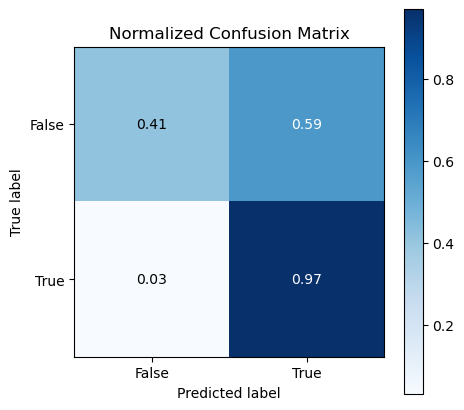

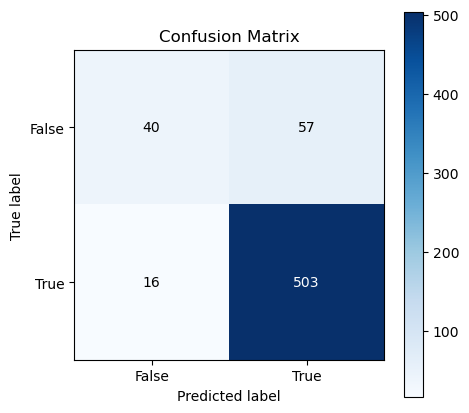

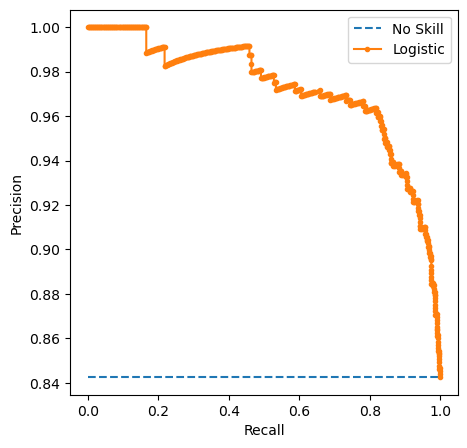

In [22]:
plt.rcParams["figure.figsize"] = (5,5)

y_true = [False if l is None else l for l in list(test.Label.values)]
acc_one = describe_evaluation(y_true, probs_test)

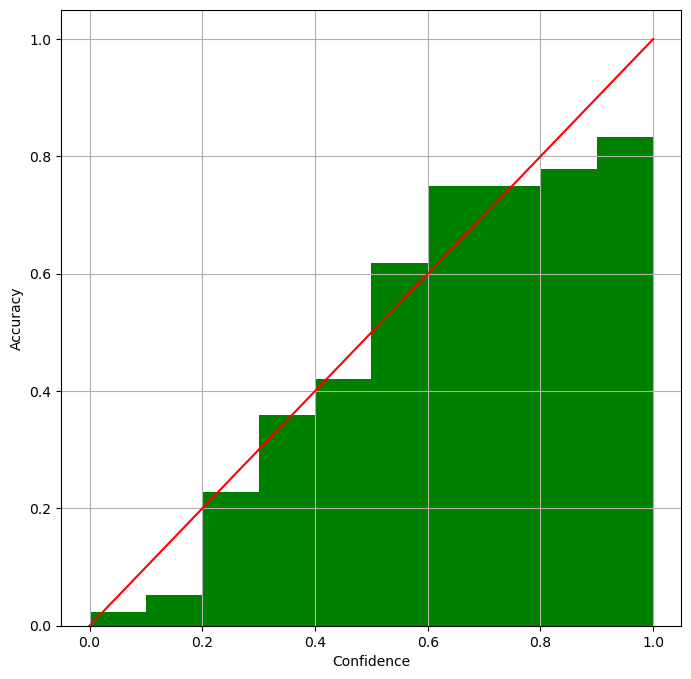

0.04448746276701039


In [23]:
# Calibration error
plt.rcParams["figure.figsize"] = (8,8)
cal_loss_one = plot_calibration(np.array(y_true), probs_test, 0)
print(cal_loss_one)

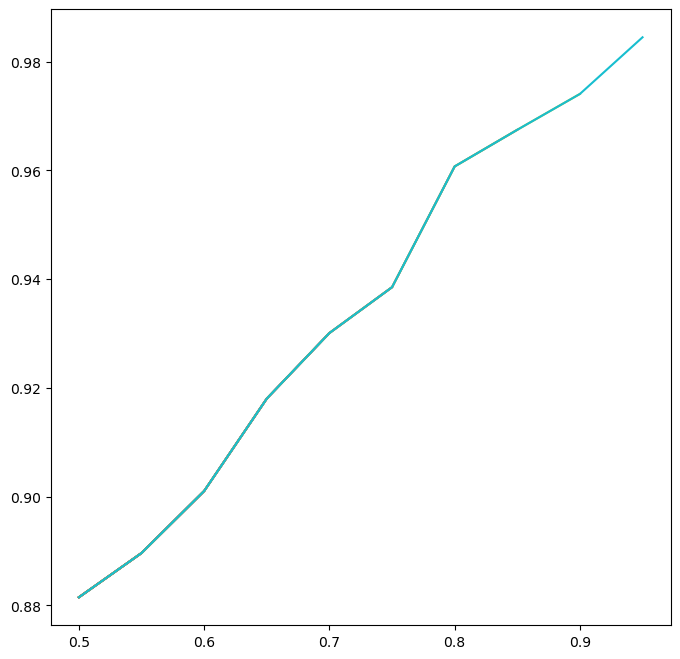

In [24]:
# Confidence
plot_confidence_inc(y_true, probs_test)

### 2. Labeled samples per class: 16

In [25]:
pred_train, probs_train, pred_test, probs_test = get_predictions_setfit(train, test, st_model = model_two, seed= 15)

The amount of inference time required on A100 GPU is 79614.82800000001 milliseconds.


Evaluation accuracy : 0.8863636363636364
F1=0.935 AUC=0.974


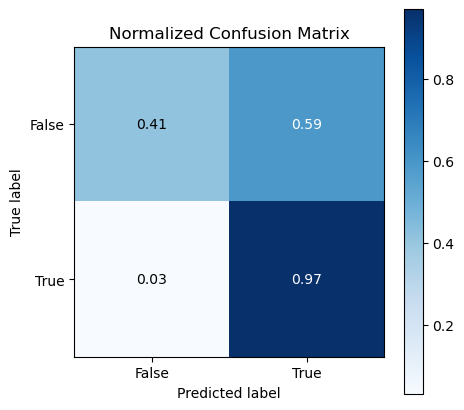

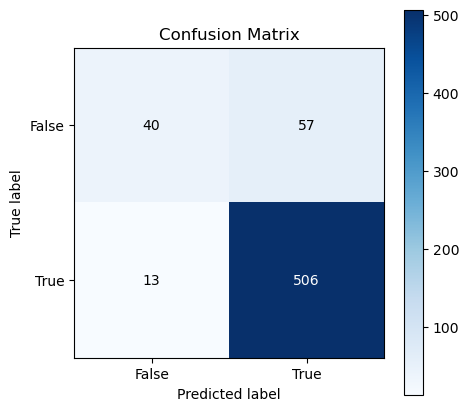

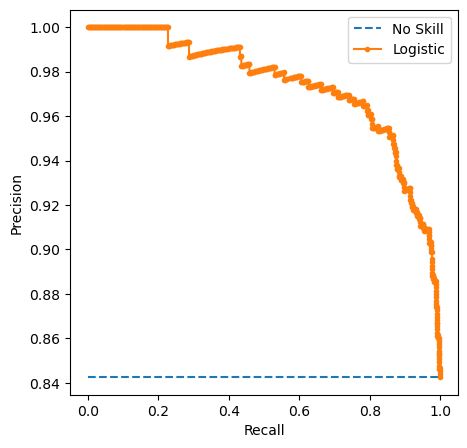

In [26]:
plt.rcParams["figure.figsize"] = (5,5)

y_true = [False if l is None else l for l in list(test.Label.values)]
acc_two = describe_evaluation(y_true, probs_test)

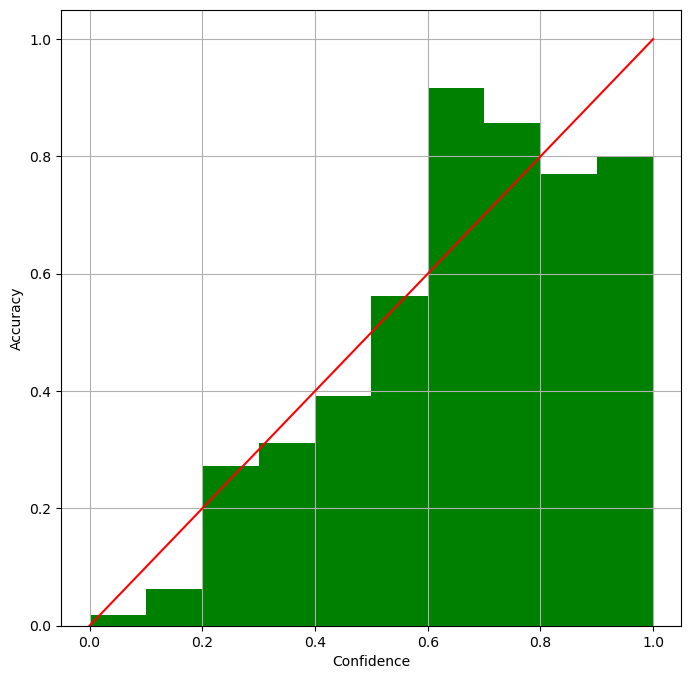

0.052897275526507345


In [27]:
# Calibration error
plt.rcParams["figure.figsize"] = (8,8)
cal_loss_two = plot_calibration(np.array(y_true), probs_test, 0)
print(cal_loss_two)

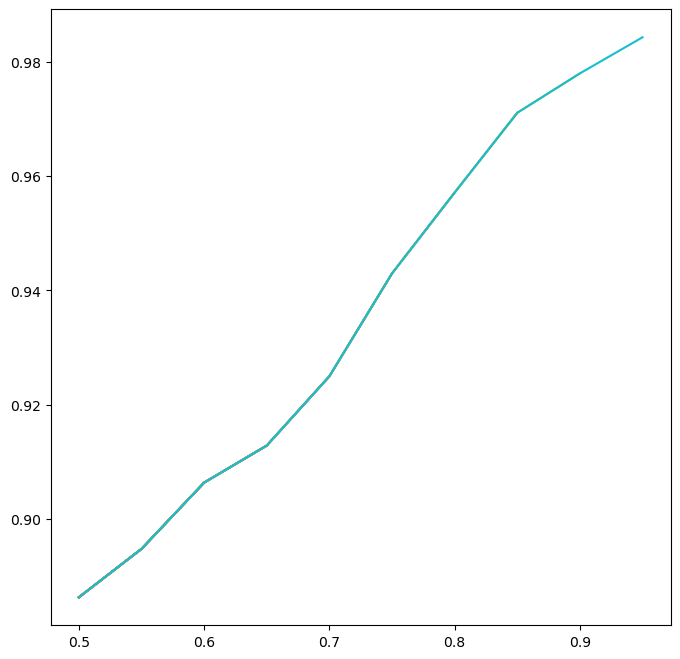

In [28]:
# Confidence
plot_confidence_inc(y_true, probs_test)

### 3. Labeled samples per class: 32

In [29]:
pred_train, probs_train, pred_test, probs_test = get_predictions_setfit(train, test, st_model = model_three, seed= 15)

The amount of inference time required on A100 GPU is 81202.933 milliseconds.


Evaluation accuracy : 0.8863636363636364
F1=0.936 AUC=0.976


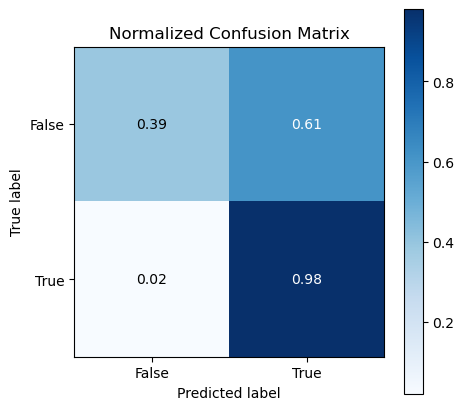

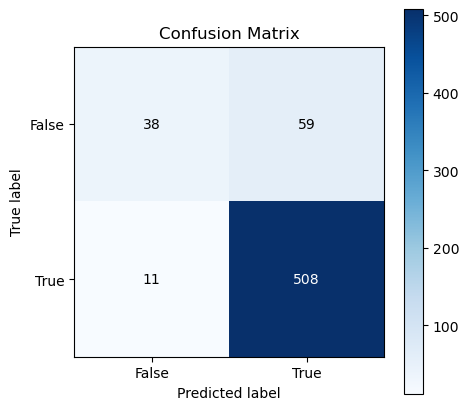

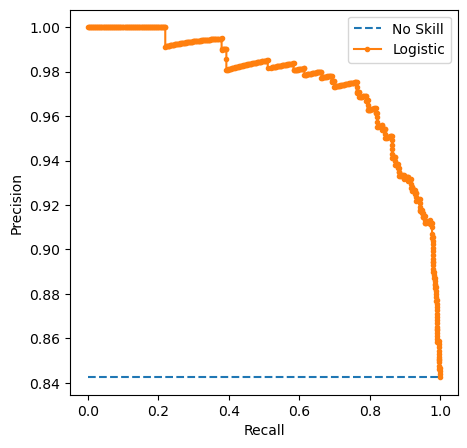

In [30]:
plt.rcParams["figure.figsize"] = (5,5)

y_true = [False if l is None else l for l in list(test.Label.values)]
acc_three = describe_evaluation(y_true, probs_test)

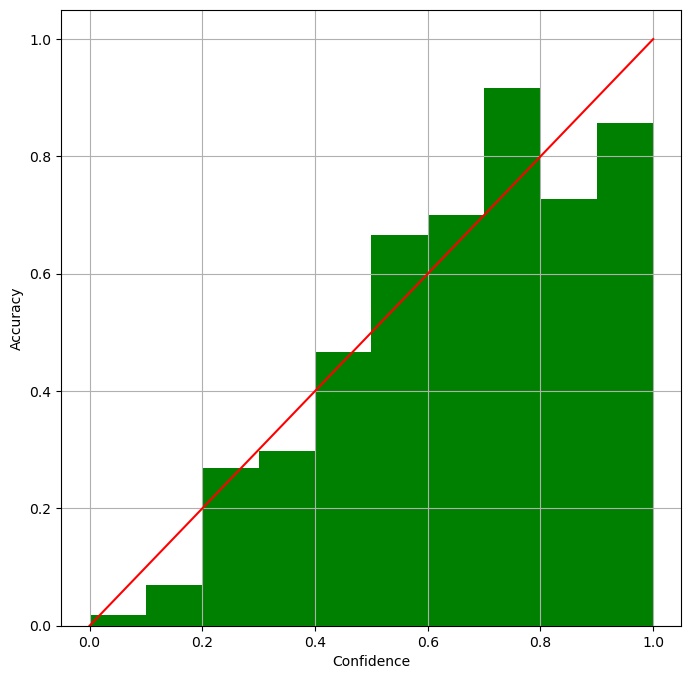

0.052073526889925996


In [31]:
# Calibration error
plt.rcParams["figure.figsize"] = (8,8)
cal_loss_three = plot_calibration(np.array(y_true), probs_test, 0)
print(cal_loss_three)

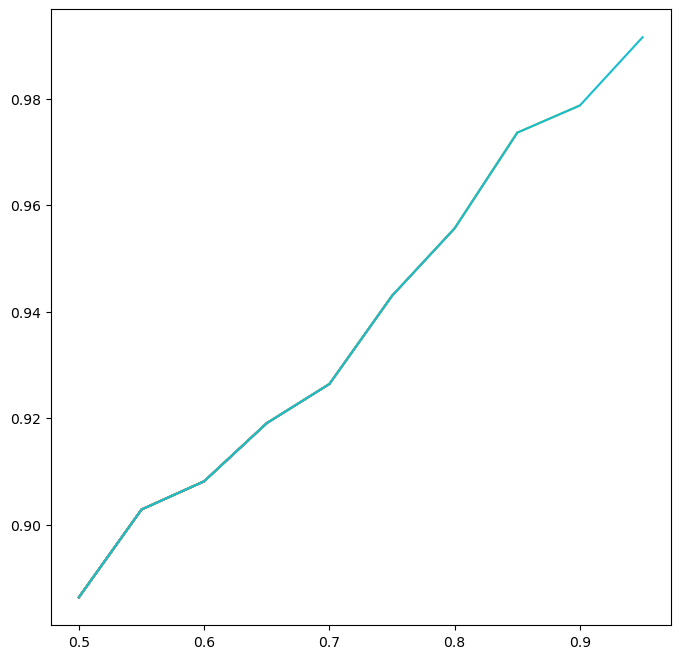

In [32]:
# Confidence
plot_confidence_inc(y_true, probs_test)

### 4. Labeled samples per class: 64

In [33]:
pred_train, probs_train, pred_test, probs_test = get_predictions_setfit(train, test, st_model = model_four, seed= 15)

The amount of inference time required on A100 GPU is 76322.473 milliseconds.


Evaluation accuracy : 0.8798701298701299
F1=0.931 AUC=0.981


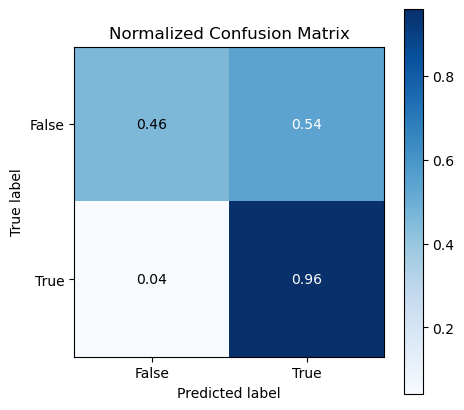

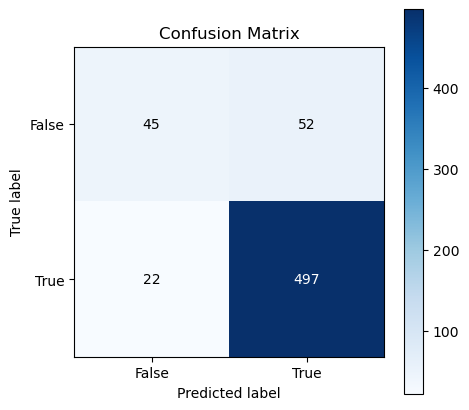

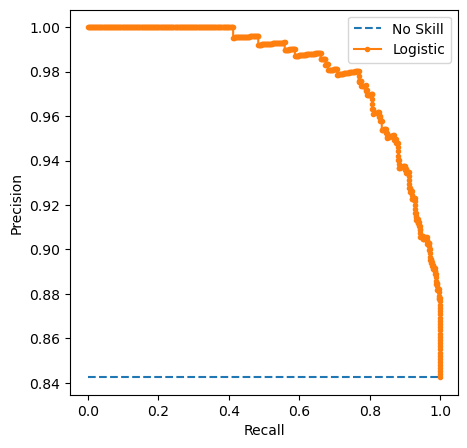

In [34]:
plt.rcParams["figure.figsize"] = (5,5)

y_true = [False if l is None else l for l in list(test.Label.values)]
acc_four = describe_evaluation(y_true, probs_test)

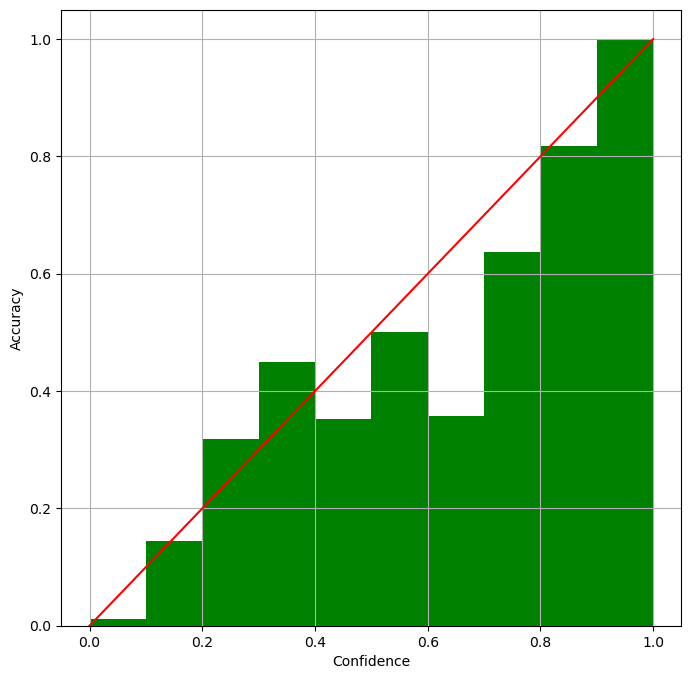

0.05043014234306585


In [35]:
# Calibration error
plt.rcParams["figure.figsize"] = (8,8)
cal_loss_four = plot_calibration(np.array(y_true), probs_test, 0)
print(cal_loss_four)

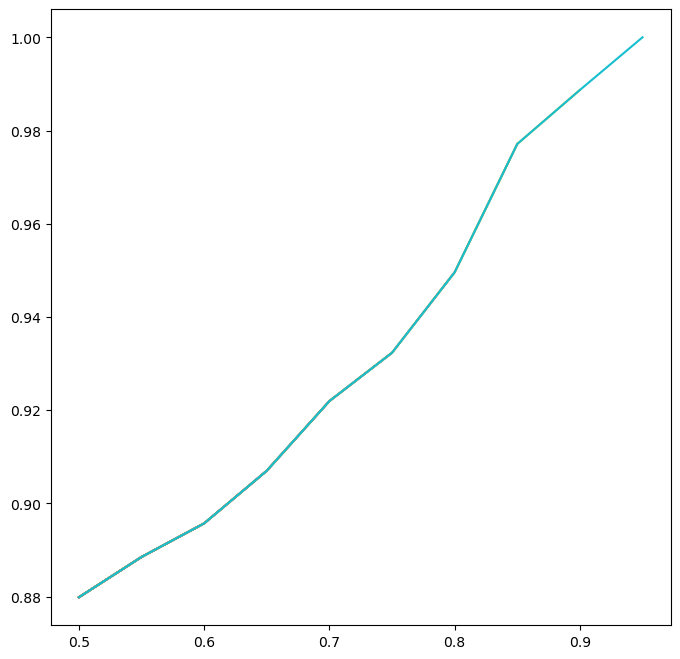

In [36]:
# Confidence
plot_confidence_inc(y_true, probs_test)

### 5. Labeled samples per class: 128

In [37]:
pred_train, probs_train, pred_test, probs_test = get_predictions_setfit(train, test, st_model = model_five, seed= 15)

The amount of inference time required on A100 GPU is 80715.118 milliseconds.


Evaluation accuracy : 0.8961038961038961
F1=0.941 AUC=0.972


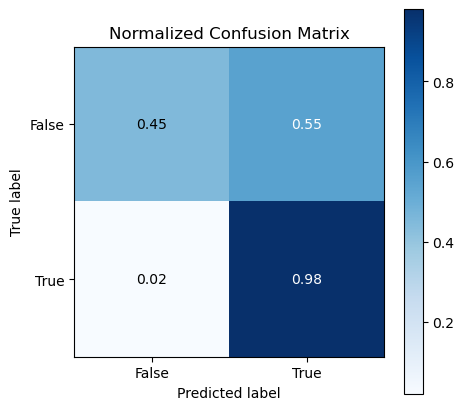

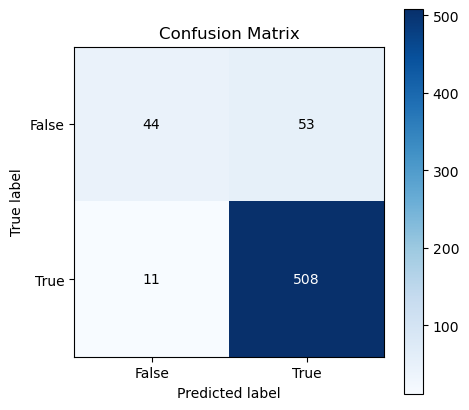

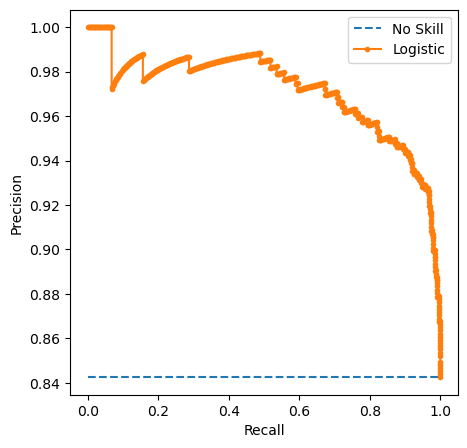

In [38]:
plt.rcParams["figure.figsize"] = (5,5)

y_true = [False if l is None else l for l in list(test.Label.values)]
acc_five = describe_evaluation(y_true, probs_test)

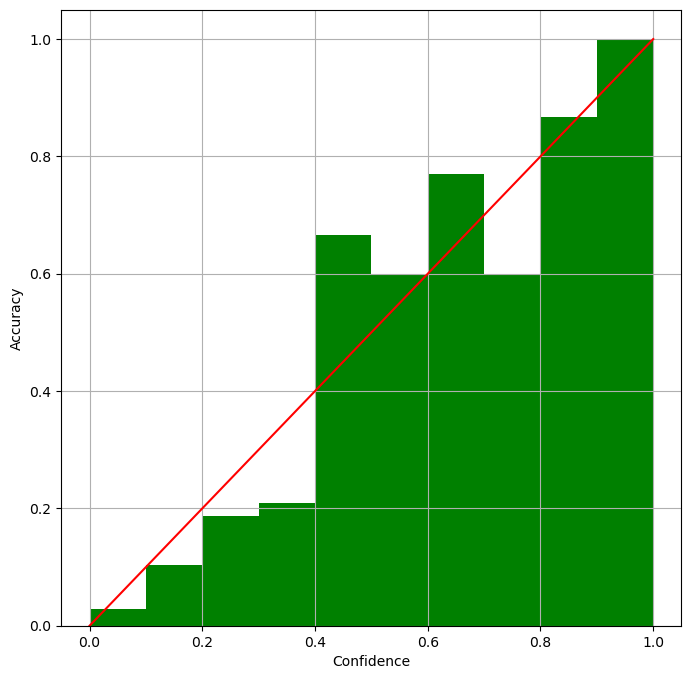

0.0500281110736833


In [39]:
# Calibration error
plt.rcParams["figure.figsize"] = (8,8)
cal_loss_five = plot_calibration(np.array(y_true), probs_test, 0)
print(cal_loss_five)

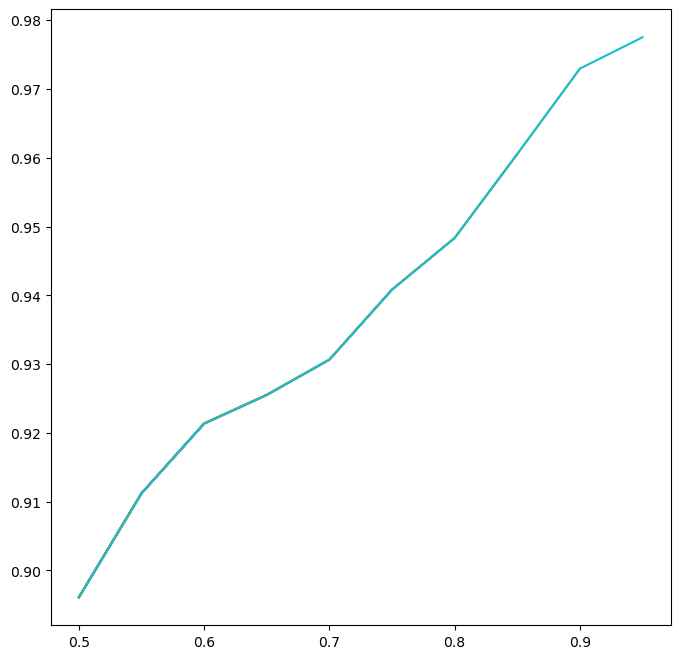

In [40]:
# Confidence
plot_confidence_inc(y_true, probs_test)

### 6. Labeled samples per class: 256

In [41]:
pred_train, probs_train, pred_test, probs_test = get_predictions_setfit(train, test, st_model = model_six, seed= 15)

The amount of inference time required on A100 GPU is 98800.713 milliseconds.


Evaluation accuracy : 0.8766233766233766
F1=0.930 AUC=0.963


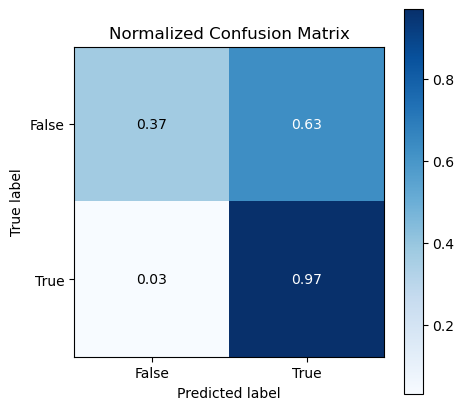

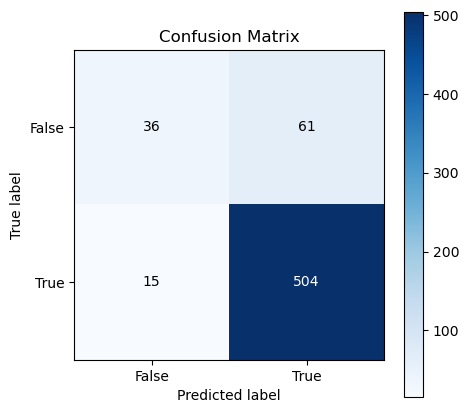

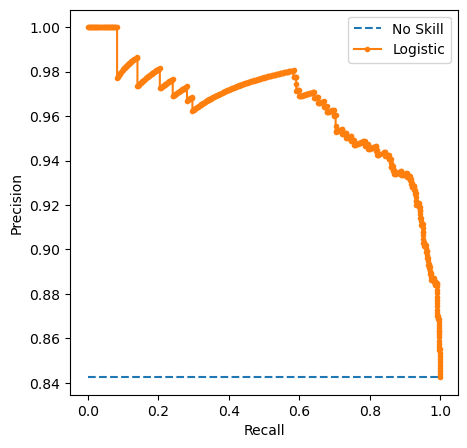

In [42]:
plt.rcParams["figure.figsize"] = (5,5)

y_true = [False if l is None else l for l in list(test.Label.values)]
acc_six = describe_evaluation(y_true, probs_test)

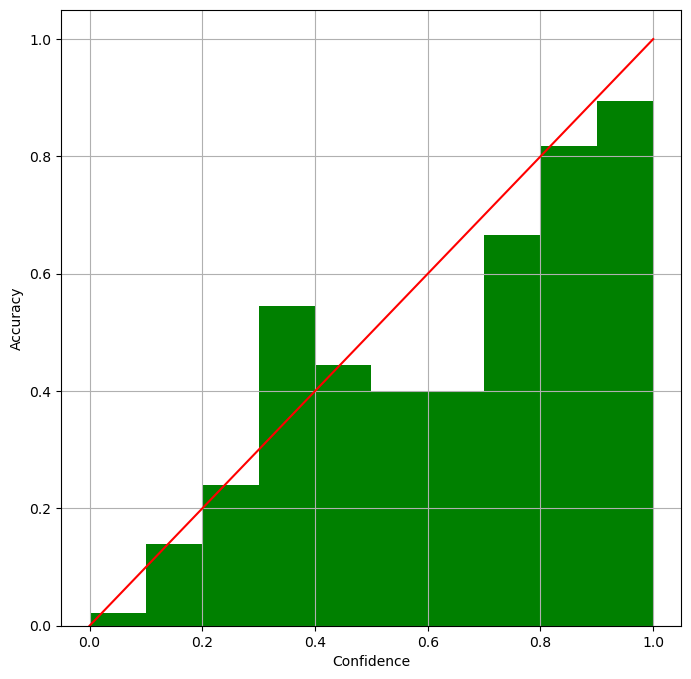

0.03851598377427533


In [43]:
# Calibration error
plt.rcParams["figure.figsize"] = (8,8)
cal_loss_six = plot_calibration(np.array(y_true), probs_test, 0)
print(cal_loss_six)

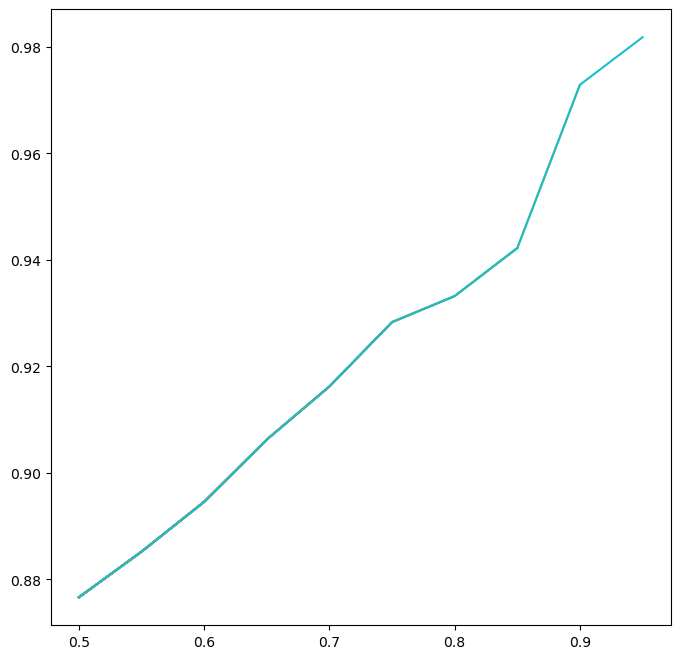

In [44]:
# Confidence
plot_confidence_inc(y_true, probs_test)

### 7. Labeled samples per class: 512

In [45]:
pred_train, probs_train, pred_test, probs_test = get_predictions_setfit(train, test, st_model = model_seven, seed= 15)

The amount of inference time required on A100 GPU is 77711.074 milliseconds.


Evaluation accuracy : 0.8961038961038961
F1=0.941 AUC=0.964


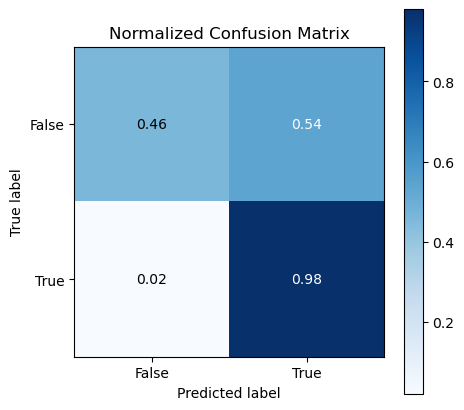

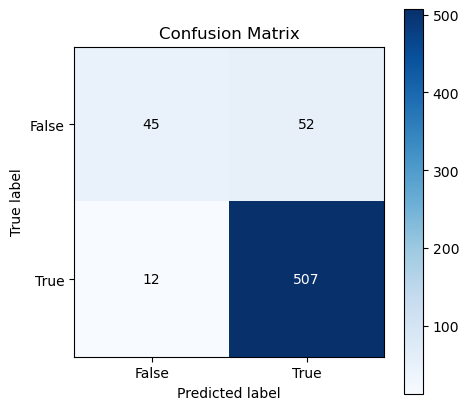

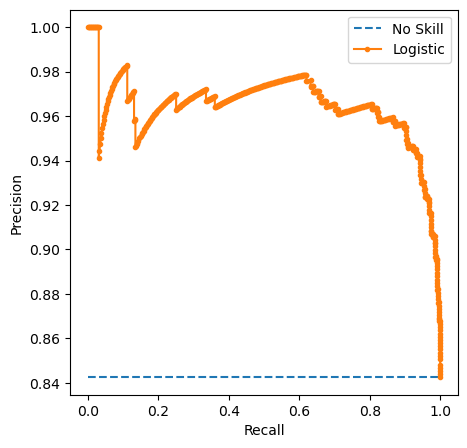

In [46]:
plt.rcParams["figure.figsize"] = (5,5)

y_true = [False if l is None else l for l in list(test.Label.values)]
acc_seven = describe_evaluation(y_true, probs_test)

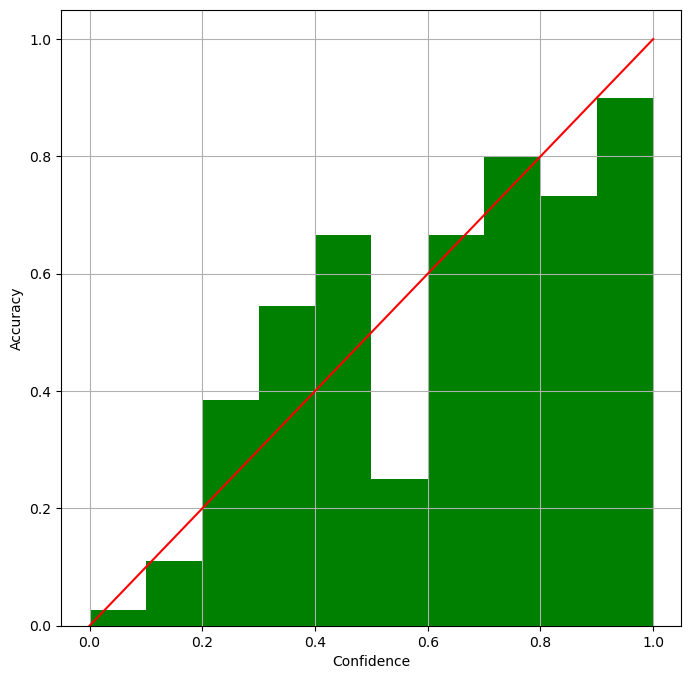

0.054790722070840875


In [47]:
# Calibration error
plt.rcParams["figure.figsize"] = (8,8)
cal_loss_seven = plot_calibration(np.array(y_true), probs_test, 0)
print(cal_loss_seven)

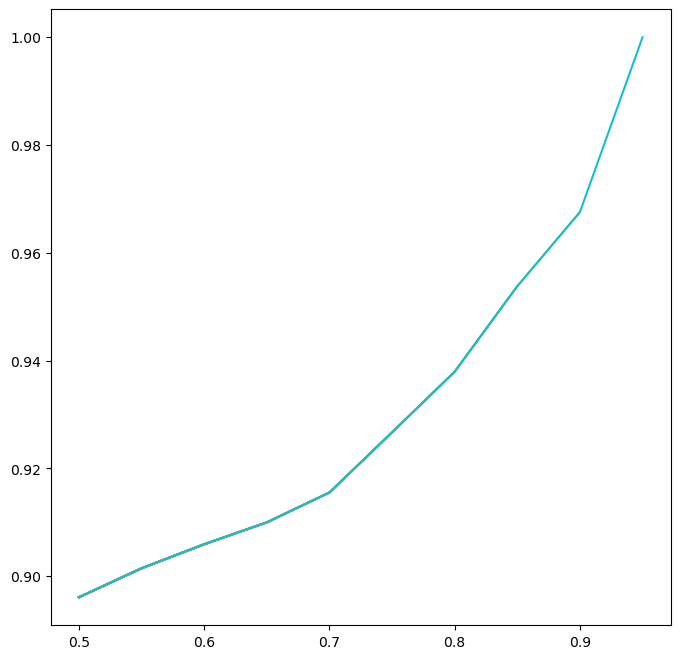

In [48]:
# Confidence
plot_confidence_inc(y_true, probs_test)

### 8. Labeled samples per class: 5100

In [49]:
pred_train, probs_train, pred_test, probs_test = get_predictions_setfit(train, test, st_model = model_eight, seed= 15)

The amount of inference time required on A100 GPU is 80881.40699999999 milliseconds.


Evaluation accuracy : 0.9383116883116883
F1=0.964 AUC=0.993


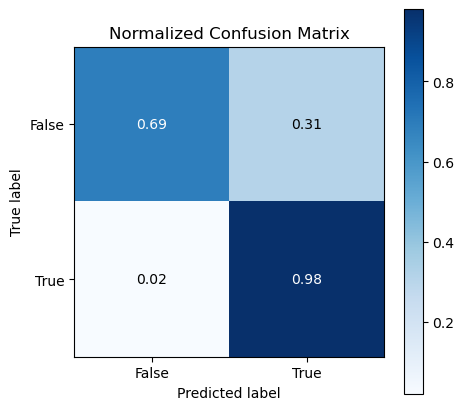

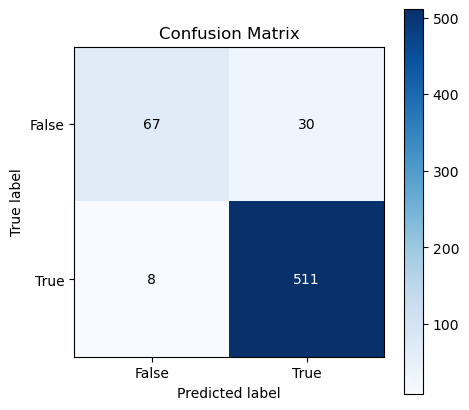

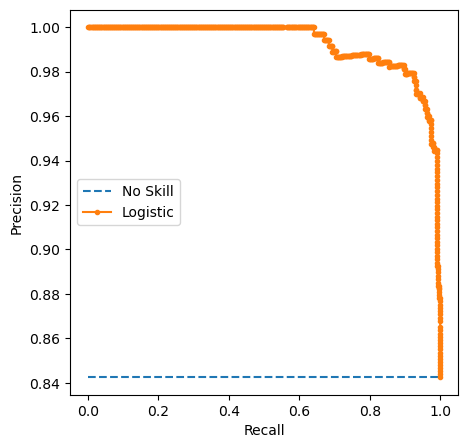

In [50]:
plt.rcParams["figure.figsize"] = (5,5)

y_true = [False if l is None else l for l in list(test.Label.values)]
acc_eight = describe_evaluation(y_true, probs_test)

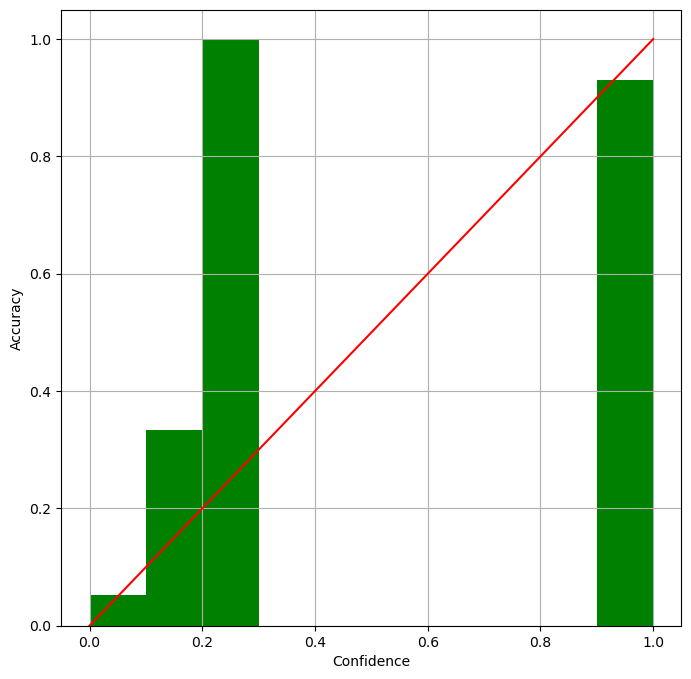

0.04384115157682157


In [51]:
# Calibration error
plt.rcParams["figure.figsize"] = (8,8)
cal_loss_eight = plot_calibration(np.array(y_true), probs_test, 0)
print(cal_loss_eight)

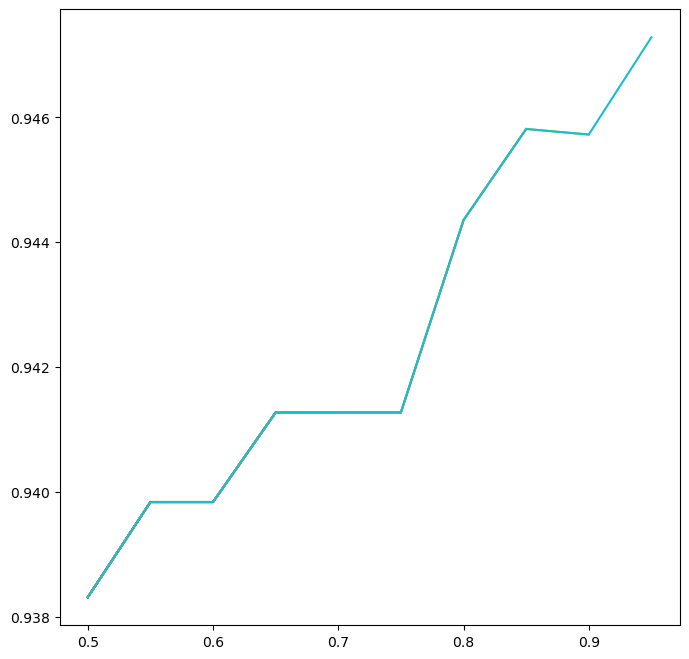

In [52]:
# Confidence
plot_confidence_inc(y_true, probs_test)

### Join accuracy and calibration loss metrics and export to csv file

In [53]:
# st_family = ['Mini LM v2'] * 8
# training_size = ['16', '32', '64', '128', '256', '512', '1024', '10200']
# accuracy_scores = [acc_one, acc_two, acc_three, acc_four, acc_five, acc_six, acc_seven, acc_eight]
# cal_loss = [cal_loss_one, cal_loss_two, cal_loss_three, cal_loss_four, cal_loss_five, cal_loss_six, cal_loss_seven, cal_loss_eight] 

# acc_df = pd.DataFrame({'Sentence Transformer':st_family, 'Training size':training_size, 'Accuracy':accuracy_scores})
# cal_loss_df = pd.DataFrame({'Sentence Transformer':st_family, 'Training size':training_size, 'Expected calibration error':cal_loss})

# # Export as csv
# acc_df.to_csv(os.path.join(output_folder, 'accuracy_scores_mini_lm.csv'), index= False)
# cal_loss_df.to_csv(os.path.join(output_folder, 'calibration_loss_mini_lm.csv'), index= False)